I will collect all analyses and plots for the soil paper in this notebook. Both read based and MAGs. The original input files are a bit scattered through the server. I will therefore only copy the relevant files for the analysis to `/storage/marwe/soil_project/manuscript_analysis/data`.

## Import libraries for Python


In [1]:
import os
import re
import math
from scipy import stats
import random
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm 
import seaborn.objects as so
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from scipy.cluster.hierarchy import linkage, leaves_list
from Bio import SeqIO
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa, OrdinationResults
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
pd.set_option('display.max_colwidth', None)

%load_ext rpy2.ipython 

## Import and clean data

Calculate gene length for all databases.

In [2]:
df_length = []
list_db = ['manuscript_analysis/databases/mobileOG/mobileOG-db_beatrix-1.6.MC.faa', 
           'manuscript_analysis/data/read_based/combined/CD_HIT/ARG_db_clstr_100.faa']

dict_length = {
    'Reference':[],
    'Length':[]
}

for db in list_db:
    for record in SeqIO.parse(db, "fasta"):
        id_ = record.id
        length = len(str(record.seq))
        dict_length["Reference"].append(id_)
        dict_length["Length"].append(length)
df_length = pd.DataFrame.from_dict(dict_length)

In [3]:
list_arg_remove = df_length[df_length.Reference.str.contains("rpoB", case=False)].Reference.unique().tolist()
list_arg_remove

['gb|BAD59497.1|ARO:3000501|rpoB2_[Nocardia_farcinica_IFM_10152]_',
 'gb|WP_041777404.1|ARO:3004480|Bado_rpoB_RIF_[Bifidobacterium_adolescentis]_']

Here I will load the raw Diamond files from the screen where I looked for ARGs in genomic islands and on plasmids

In [4]:
# Find all relevant Diamond output files
files_GI =       glob.glob("manuscript_analysis/data/read_based/combined/Diamond/ARG_GI/*.tsv")
plasmid_output = glob.glob("manuscript_analysis/data/read_based/combined/Diamond/ARG_plasmids/*.tsv")
files_mobile = files_GI + plasmid_output


diamond_output_headers = [
    "qseqid", "sseqid", "pident", "length", "mismatch", "gapopen",
    "qstart", "qend", "sstart", "send", "evalue", "bitscore"
]

def process_file(file):
    # Read files
    try:
        df_tmp = pd.read_csv(file, sep="\t", names=diamond_output_headers)
        # Some files did not wnt ot be read by the regular engine
    except pd.errors.ParserError:
        df_tmp = pd.read_csv(file, sep="\t", names=diamond_output_headers, engine='python')
    # randomly shuffle df to later be ble to randomly select best hit
    df_tmp = df_tmp.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Group by read and select best hit
    grouped = df_tmp.groupby('qseqid', group_keys=False)
    df_tmp = grouped.apply(get_best_hit, include_groups=False).reset_index(drop=True)
    return df_tmp

def get_best_hit(group):
    # This function returns the best hit for a read
    sorted_group = group.sort_values(by=['evalue', 'pident', 'length'], ascending=[True, False, False])
    return sorted_group.iloc[0]

# Select the best hit per read in a parallelized manner
with ProcessPoolExecutor(max_workers=50) as executor: 
    futures = {executor.submit(process_file, file): file for file in files_mobile}
    results = []
    # Create loading bar
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        result = future.result()
        if not result.empty: 
                results.append(result)
# Concatenate all results
df_diamond_mobile = pd.concat(results)

Processing files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30413/30413 [00:38<00:00, 799.64it/s]


Here I will load the raw Diamond files, I will then choose the best hit based on alignment criterion and output everything in a singe file.

In [5]:
# Find all relevant Diamond output files
path_ARG = glob.glob('manuscript_analysis/data/read_based/combined/Diamond/ARG/*ARG_db.tsv')
path_MGE = glob.glob('manuscript_analysis/data/read_based/combined/Diamond/ARG/*mobileOG.tsv')

list_files = [["ARG", path_ARG],["MGE", path_MGE]]

df_MGE_metadata = pd.read_csv("manuscript_analysis/databases/mobileOG/mobileOG-db-beatrix-1.6-MC_filtered.csv", sep = "\t")
MGE_list_keep = df_MGE_metadata["mobileOG fasta Header"].tolist()

# For each database
for type_, path in list_files:
    print(type_)
    diamond_output_headers = [
        "qseqid", "sseqid", "pident", "length", "mismatch", "gapopen",
        "qstart", "qend", "sstart", "send", "evalue", "bitscore"
    ]

    def process_file(file, type_):
        # Read files
        try:
            df_tmp = pd.read_csv(file, sep="\t", names=diamond_output_headers)
            # Some files did not wnt ot be read by the regular engine
        except pd.errors.ParserError:
            df_tmp = pd.read_csv(file, sep="\t", names=diamond_output_headers, engine='python')

        # Only keep hits with this ID or above
        df_tmp = df_tmp[df_tmp.pident >= 90]
        if type_ == "ARG":
            df_tmp = df_tmp[~df_tmp.sseqid.isin(list_arg_remove)]
        elif type_ == "MGE":
            # Only keep MGEs relevant to ARGs
            df_tmp = df_tmp[df_tmp.sseqid.isin(MGE_list_keep)]
        
        # Identify file metadata
        name = file.split('/')[-1].replace('_ARG_db.tsv' ,'').replace('_mobileOG.tsv', '')
        df_tmp['Sample'] = name

        # randomly shuffle df to later be ble to randomly select best hit
        df_tmp = df_tmp.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Group by read and select best hit
        grouped = df_tmp.groupby('qseqid', group_keys=False)
        df_tmp = grouped.apply(get_best_hit, include_groups=False).reset_index(drop=True)
        return df_tmp

    def get_best_hit(group):
        
        # This function returns the best hit for a read
        sorted_group = group.sort_values(by=['evalue', 'pident', 'length'], ascending=[True, False, False])
        return sorted_group.iloc[0]

    # Select the best hit per read in a parallelized manner
    if __name__ == '__main__':
        with ProcessPoolExecutor(max_workers=50) as executor: 
            futures = {executor.submit(process_file, file, type_): file for file in path}
            results = []

            # Create loading bar
            for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
                result = future.result()
                results.append(result)

    # Concatenate all results
    df_diamond = pd.concat(results)        
    df_diamond.to_csv(f'manuscript_analysis/data/read_based/combined/Diamond/Diamond_cat_{type_}.tsv', sep='\t')
    
    if type_ == "ARG":
        df_ARG = df_diamond
    elif type_ == "MGE":
        df_MGE = df_diamond

ARG


Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:12<00:00,  6.17it/s]


MGE


Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:26<00:00,  2.91it/s]


Import Mumame data

In [6]:
mumame_input_files = glob.glob("manuscript_analysis/data/read_based/combined/Mumame/*table.txt")

mumame_results_list = []

for file in mumame_input_files:
    df_tmp = pd.read_csv(file, sep = "\t", header=0, usecols=[0, 1], names = ["Mutation", "Count"])
    name = file.split('/')[-1].replace(".table.txt", "")
    df_tmp["Sample"] = name
    # Remove last rows which contain teh number of reads per sample
    df_tmp = df_tmp[:-1]
    # Remove rows with only WT 
    df_tmp = df_tmp[~df_tmp.Mutation.str.contains("Wildtype")]
    mumame_results_list.append(df_tmp)

df_mumame = pd.concat(mumame_results_list)


Load the nr of bacteria per sample.

In [7]:
list_kingdoms = ["manuscript_analysis/data/read_based/non_inv/metaxa2_dc/Combined_level_1.txt",
                 "manuscript_analysis/data/read_based/input/metaxa2_dc/Combined_level_1.txt"]

list_genera = ["manuscript_analysis/data/read_based/non_inv/metaxa2_dc/Combined_level_6.txt",
                 "manuscript_analysis/data/read_based/input/metaxa2_dc/Combined_level_6.txt"]

def parse_Taxonomy(list_files):
    # List to store taxonomy data
    tmp_list = []
    # For each taxa file read it and melt to long df
    for file in list_files:
        df_taxonomy = pd.read_csv(file, sep="\t")
        df_taxonomy.columns.values[0] = 'Taxa'
        # If kingdom file
        if "level_1" in file:
            df_taxonomy = df_taxonomy[df_taxonomy.Taxa == "Bacteria"].drop(["Taxa"], axis=1).melt()
        # If genera file
        else:
            df_taxonomy = df_taxonomy.melt(id_vars=['Taxa']) 
        # Combine to single file  and rename columns  
        tmp_list.append(df_taxonomy)
    df_cat = pd.concat(tmp_list)
    df_cat = df_cat.rename(columns={"variable": "Sample", "value": "nr_16s"})     
    # change to consistent sample naming between ARGs and taxonomy
    df_cat["Sample"] = df_cat.Sample.str.replace("_non_inv", "") 
    modified_array = np.array([('input_' + col) if  not col[1] == 'd' else col for col in df_cat.Sample])
    df_cat["Sample"] = modified_array
    return df_cat

df_kingdom = parse_Taxonomy(list_kingdoms)
df_genera = parse_Taxonomy(list_genera)

The next step is to take the databases which were clustered at 95% and identify each cluster representative, as well as all its members.

In [8]:
def parse_clstr_file(file_path):

    """
    This function takes the cluster file from CD-HIT and parses it.
    It returns a df with the representative and members of each cluster.
    """
    
    # Initialize the dictionary to store References and their corresponding clusters
    member_to_Reference = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # Generates a list of clusters
        clstr_list = '.'.join(lines).split(">Cluster ")
        
        # first entry in the list is empty
        for cluster in clstr_list[1:]:
            # List of members in a cluster
            cluster_tmp = [x for x in cluster.split(', ')[1:]]
            
            # If cluster representative
            for entry in cluster_tmp:
                if '*' in entry:
                    # Get sequence name
                    Reference = entry.split('...')[0].split('>')[1]
                    break
               # Add all cluster members 
            for items in cluster_tmp:
                member = items.split('...')[0].split('>')[1]
                member_to_Reference[member] = Reference
              
    df = pd.DataFrame(list(member_to_Reference.items()), columns=['sseqid', 'Reference'])  
    
    return df
df_cluster_ARG = parse_clstr_file('manuscript_analysis/data/read_based/combined/CD_HIT/ARG_db_95.clstr')
df_cluster_MGE = parse_clstr_file('manuscript_analysis/data/read_based/combined/CD_HIT/mobileOG_95.clstr')

Now I want to annotate if the ARGs are preset on mobile genetic elements. I did this by  screening predicted proteins from the ARG db against plasmids and genomic islands. 

In [9]:
# Non redundant list of ARGs    
list_mobile_ARGs = list(set(df_diamond_mobile.sseqid.unique()))

# Annotate if cluster contains plasmid ARG
df_cluster_ARG["Mobile"] = np.where(df_cluster_ARG["sseqid"].isin(list_mobile_ARGs), "Yes", "No")
df_cluster_ARG_plasmid = df_cluster_ARG[["Mobile", "Reference"]].drop_duplicates()

dict_plasmid = {
    "Reference":[],
    "Mobile":[]
}

# Annotates Yes if any member in the CD-HIT cluster was detected in a plasmid.
# Otherwise no
for ARG in df_cluster_ARG_plasmid.Reference.unique():
    df_tmp = df_cluster_ARG_plasmid[df_cluster_ARG_plasmid.Reference == ARG]
    if "Yes" in df_tmp.Mobile.tolist():
        dict_plasmid["Mobile"].append("Yes")
        dict_plasmid["Reference"].append(ARG)
    elif "No" and not "Yes" in df_tmp.Mobile.tolist():
        dict_plasmid["Mobile"].append("No")
        dict_plasmid["Reference"].append(ARG)
        
df_cluster_ARG_plasmid = pd.DataFrame.from_dict(dict_plasmid)

Import ARG data from MAGs

In [10]:
ARG_genome_input_files = glob.glob("manuscript_analysis/data/read_based/combined/Diamond/ARG_genomes/*.tsv")

ARG_genome_list = []

diamond_output_headers = [
        "qseqid", "sseqid", "pident", "length", "mismatch", "gapopen",
        "qstart", "qend", "sstart", "send", "evalue", "bitscore"
    ]

for file in ARG_genome_input_files:
    df_tmp = pd.read_csv(file, sep = "\t", names = diamond_output_headers)
    name = file.split('/')[-1].replace("_ARG_db.tsv", "")
    df_tmp["Sample"] = name
    df_tmp = df_tmp.sample(frac=1, random_state=42).reset_index(drop=True)
           
    # randomly shuffle df to later be ble to randomly select best hit
    df_tmp = df_tmp.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Group by read and select best hit
    grouped = df_tmp.groupby('qseqid', group_keys=False)
    df_tmp = grouped.apply(get_best_hit, include_groups=False)
    if  not df_tmp.empty:
        ARG_genome_list.append(df_tmp)

df_MAG_ARG = pd.concat(ARG_genome_list)

Add metadata and normalize gene counts

In [11]:
# Add cluster assignment for genes
df_ARG_normalized = pd.merge(df_ARG, df_cluster_ARG, on = "sseqid")
df_MGE_normalized  = pd.merge(df_MGE, df_cluster_MGE, on = "sseqid")
df_MAG_ARG = pd.merge(df_MAG_ARG, df_cluster_ARG, on = "sseqid")

# Sum gene counts
df_ARG_normalized = df_ARG_normalized.groupby(["Sample"]).Reference.value_counts().reset_index(name='Count')
df_MGE_normalized = df_MGE_normalized.groupby(["Sample"]).Reference.value_counts().reset_index(name='Count')

# Add if ARG was found on plasmid
df_ARG_normalized = pd.merge(df_ARG_normalized, df_cluster_ARG_plasmid[["Reference", "Mobile"]], on = "Reference")

# Add nr 16s
df_ARG_normalized = pd.merge(df_ARG_normalized, df_kingdom, on = "Sample")
df_MGE_normalized = pd.merge(df_MGE_normalized, df_kingdom, on = "Sample")
df_mumame_normalized = pd.merge(df_mumame, df_kingdom, on = "Sample")

# Add gene length
df_ARG_normalized = pd.merge(df_ARG_normalized, df_length, on = "Reference")
df_MGE_normalized = pd.merge(df_MGE_normalized, df_length, on = "Reference")

df_ARG_normalized['Count_normalized'] = (df_ARG_normalized['Count'] / df_ARG_normalized['Length']) / (df_ARG_normalized['nr_16s'] / 720)
df_MGE_normalized['Count_normalized'] = (df_MGE_normalized['Count'] / df_MGE_normalized['Length']) / (df_MGE_normalized['nr_16s'] / 720)
df_mumame_normalized['Count_normalized'] = (df_mumame_normalized['Count'] / 720)

# Read CARD metadata
df_CARD_meta = pd.read_csv("manuscript_analysis/databases/CARD_data/aro_index.tsv", sep="\t", usecols=["ARO Accession", "Drug Class"])

# Add Major MGE category

MGE_metadata_type = df_MGE_metadata[["mobileOG fasta Header", "Type"]]
MGE_metadata_type["id"] = MGE_metadata_type["mobileOG fasta Header"].str.split("|").str[0]
df_MGE_normalized["id"] = df_MGE_normalized["Reference"].str.split("|").str[0]
df_MGE_normalized = pd.merge(df_MGE_normalized, MGE_metadata_type, 
                             on = "id",
                             how = "left") 
df_MGE_normalized = df_MGE_normalized.drop(columns=['id'])
# Extract AROs from fasta names and merge with CARD reference sheet
df_ARG_normalized["ARO Accession"] = df_ARG_normalized.Reference.str.split("|").str[2]
df_ARG_normalized = pd.merge(df_ARG_normalized, df_CARD_meta, on ="ARO Accession", how="left")

# Split ResFinder into its own df to add drug class
# Extract the ResFinderFG rows
df_tmp_resfinderfg = df_ARG_normalized[df_ARG_normalized["Drug Class"].isna()].copy()

# Read ResFinderFG metadata sheet
df_meta_FG = pd.read_csv("manuscript_analysis/databases/ResFinderFG/ResFinderFG_gene_classified.csv", sep = ";")

# Replace spaces was also done for fasta heder
df_meta_FG["Annotation"] = df_meta_FG.Annotation.str.replace(" ", "_")

# Add metadata
df_tmp_resfinderfg["DB"] = "RefFinderGF"
df_tmp_resfinderfg["Annotation"] = df_tmp_resfinderfg.Reference.str.split("|").str[0]
df_tmp_resfinderfg = pd.merge(df_tmp_resfinderfg, df_meta_FG, on="Annotation", how="left")

# Rename labels to look nicer
category_mapping = {
    'cycline': 'Tetracyclines',
    'Sulfonamide/trimethoprim': 'Sulfonamides/Trimethoprim',
    'Glycopeptide/cycloserine': 'Glycopeptides/Cycloserine',
    'aminoside': 'Aminoglycosides',
    'blactamase': 'Beta-lactamases',
    'phenicol': 'Phenicols',
    'MLS': 'Macrolides/Lincosamides/Streptogramins'
}
df_tmp_resfinderfg['Drug Class'] = df_tmp_resfinderfg['Class'].map(category_mapping)

# Now we need to work a bit on the CARD data
df_tmp_CARD = df_ARG_normalized[~df_ARG_normalized["Drug Class"].isna()].copy()

def CARD_drug_class_tr(name):
    """
    Returns:
    str: The categorized drug class. Possible return values are:
         - "Beta-lactams" if all drugs in the input are beta-lactams
         - "MLS" if all drugs in the input are MLS antibiotics
         - The original input if it's a single drug class not in the above categories
         - "Multiple" if the input contains multiple drug classes not in the above categories
    """
    beta_lactams = set(['carbapenem', 'cephalosporin', 'cephamycin', 'monobactam', 'penam', 'penem'])
    mls_antibiotics = set(['macrolide antibiotic', 'lincosamide antibiotic', 'streptogramin antibiotic', 'streptogramin A antibiotic', 'streptogramin B antibiotic'])

    list_entry = name.split(";")
    if set(list_entry).issubset(beta_lactams) == True:
        return "Beta-lactamases"
    elif set(list_entry).issubset(mls_antibiotics) == True:
        return "MLS"
    
    if set(list_entry).issubset(beta_lactams) == False and set(list_entry).issubset(mls_antibiotics) == False: 
        if ";" not in name:
            return name
        else:
            return "Multiple"

# Apply function
df_tmp_CARD['Drug Class'] = df_tmp_CARD['Drug Class'].apply(CARD_drug_class_tr)        
df_tmp_CARD["DB"] = "CARD"
# Remove non antibiotics 
list_non_an_CARD = ["disinfecting agents and antiseptics", "antibacterial free fatty acids"]
df_tmp_CARD = df_tmp_CARD[~df_tmp_CARD['Drug Class'].isin(list_non_an_CARD)]

# merge REsFinderGF and CARD df
# First drop unnecessary columns
df_tmp_resfinderfg = df_tmp_resfinderfg.drop(columns=['ARO Accession', 'Annotation', "Class"])
df_tmp_CARD = df_tmp_CARD.drop(columns=['ARO Accession'])

df_ARG_normalized = pd.concat([df_tmp_CARD,df_tmp_resfinderfg])

harmonized_category_mapping = {
    'Multiple': 'Multiple',
    'glycopeptide antibiotic': 'Glycopeptides/Cycloserine',
    'rifamycin antibiotic': 'Rifamycins',
    'aminocoumarin antibiotic': 'Aminocoumarins',
    'Macrolides/Lincosamides/Streptogramins': 'MLS',
    'tetracycline antibiotic': 'Tetracyclines',
    'fluoroquinolone antibiotic': 'Fluoroquinolones',
    'mupirocin-like antibiotic': 'Mupirocin-like',
    'aminoglycoside antibiotic': 'Aminoglycosides',
    'peptide antibiotic': 'Peptides',
    'phenicol antibiotic': 'Phenicols',
    'nitroimidazole antibiotic': 'Nitroimidazoles',
    'diaminopyrimidine antibiotic': 'Sulfonamides/Trimethoprim',
    'Beta-lactams': 'Beta-lactams',
    'sulfonamide antibiotic': 'Sulfonamides/Trimethoprim',
    'elfamycin antibiotic': 'Elfamycins',
    'phosphonic acid antibiotic': 'Phosphonic acids',
    'pleuromutilin antibiotic': 'Pleuromutilins',
    'bicyclomycin-like antibiotic': 'Bicyclomycin-like',
    'fusidane antibiotic': 'Fusidanes',
    'nucleoside antibiotic': 'Nucleosides',
    'cycline': 'Tetracyclines',
    'Sulfonamide/trimethoprim': 'Sulfonamides/Trimethoprim',
    'Glycopeptide/cycloserine': 'Glycopeptides/Cycloserine',
    'aminoside': 'Aminoglycosides',
    'blactamase': 'Beta-lactams',
    'phenicol': 'Phenicols'
}
df_ARG_normalized['Drug Class'] = df_ARG_normalized['Drug Class'].map(harmonized_category_mapping).fillna(df_ARG_normalized['Drug Class'])

/tmp/ipykernel_60262/2675226953.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MGE_metadata_type["id"] = MGE_metadata_type["mobileOG fasta Header"].str.split("|").str[0]


Plot prop ARG found on plasmids

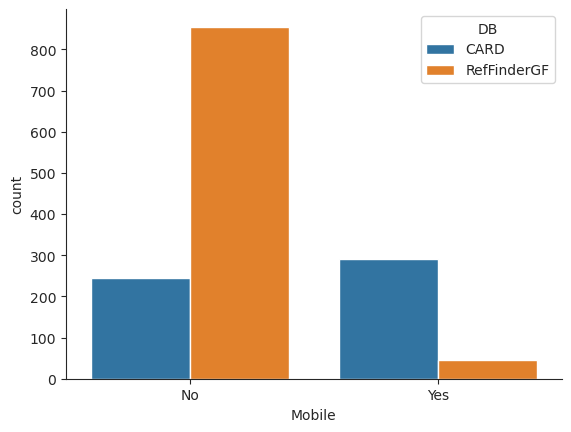

In [12]:
df_arg_db_count_plasmid = df_ARG_normalized[["Reference", "Mobile", "DB"]].drop_duplicates().groupby(["Mobile", "DB"]).Mobile.value_counts().reset_index()
sns.set_style("ticks")
sns.color_palette()[0:1]
plot_Mobile = sns.barplot(df_arg_db_count_plasmid, x="Mobile", y="count", hue="DB")

sns.despine()


**Figure**. Shows the number of ARG clusters at 95% which has at least one member detected on a plasmid per database. 

**Conclusion:** A majority of ARGs were not found on plasmids. It does however seem like there was a larger proportion of ARGs from CARD founds on plasmids. This might be a result of these ARGs common from more clinical settings while the ones from ResFinderFG might come less investigated environments. 

Below I have investigated what drug classes were found, or not found on plasmids. 

In [13]:
x_tmp = df_ARG_normalized[["Drug Class", "Mobile"]].drop_duplicates()
# Group by Drug Class and get unique values for Mobile
grouped = x_tmp.groupby('Drug Class')['Mobile'].unique()

# Create the three lists
both_yes_and_no = [drug for drug, plasmid in grouped.items() if set(plasmid) == {'Yes', 'No'}]
only_yes = [drug for drug, plasmid in grouped.items() if set(plasmid) == {'Yes'}]
only_no = [drug for drug, plasmid in grouped.items() if set(plasmid) == {'No'}]

# Print the results
print("Drug Classes with genes both present and absent on plasmids:")
print(both_yes_and_no)
print("\nDrug Classes only found on plasmids:")
print(only_yes)
print("\nDrug Classes not found on plasmids:")
print(only_no)

Drug Classes with genes both present and absent on plasmids:
['Aminocoumarins', 'Aminoglycosides', 'Beta-lactamases', 'Fluoroquinolones', 'Glycopeptides/Cycloserine', 'MLS', 'Multiple', 'Mupirocin-like', 'Peptides', 'Phenicols', 'Phosphonic acids', 'Rifamycins', 'Sulfonamides/Trimethoprim', 'Tetracyclines']

Drug Classes only found on plasmids:
['Bicyclomycin-like', 'Elfamycins', 'Nitroimidazoles']

Drug Classes not found on plasmids:
['Fusidanes', 'Nucleosides', 'Pleuromutilins']


In [14]:
df_counts = df_ARG_normalized[["Sample", "Drug Class"]].drop_duplicates()["Drug Class"].value_counts() / 77 * 100
df_counts = df_counts.reset_index()
df_counts["count"] = round(df_counts["count"], 1)
df_counts

,Drug Class,count
0,Glycopeptides/Cycloserine,100.0
1,Multiple,100.0
2,Rifamycins,100.0
3,Aminocoumarins,100.0
4,MLS,100.0
5,Tetracyclines,100.0
6,Fluoroquinolones,100.0
7,Aminoglycosides,100.0
8,Phenicols,100.0
9,Peptides,100.0


**Table** This table shows the percentage of samples the different drug classes were found in. I will put all categories with `count`< 90% in a category called `Others`.

In [15]:
# Classes which should be called "Others"
list_others = df_counts[df_counts["count"] < 90]["Drug Class"].tolist()
df_ARG_normalized['Drug Class'] = np.where(df_ARG_normalized['Drug Class'].isin(list_others), 'Other', df_ARG_normalized['Drug Class'])
for drug in df_ARG_normalized["Drug Class"].unique():
    print(drug)

Glycopeptides/Cycloserine
Multiple
Rifamycins
Aminocoumarins
MLS
Tetracyclines
Fluoroquinolones
Mupirocin-like
Aminoglycosides
Peptides
Phenicols
Nitroimidazoles
Beta-lactamases
Sulfonamides/Trimethoprim
Other


**Table**. These are the final harmonized drug classes.

Here I will add additional treatment metadata.

In [16]:
# Function to determine the day
def get_day(sample):
    if 'input' in sample:
        return 'Day 0'
    elif '1d' in sample:
        return 'Day 1'
    elif '8d' in sample:
        return 'Day 8'
    else:
        return np.nan

# Function to determine the treatment
def get_treatment(sample):
    if 'input' in sample:
        return 'Input'
    elif 'Cip_0.1' in sample:
        return 'Ciprofloxacin 0.1'
    elif 'Cip_10' in sample:
        return 'Ciprofloxacin 10'
    elif 'Tet_0.05' in sample:
        return 'Tetracycline 0.05'
    elif 'Tet_0.5' in sample:
        return 'Tetracycline 0.5'
    elif 'Tet_25' in sample:
        return 'Tetracycline 25'
    elif 'Ctrl' in sample:
        return 'Control'
    else:
        return np.nan

# Function to determine the replicate
def get_replicate(sample):
    if 'input' in sample:
        return sample[-2]
    else:
        return sample.split('_')[-1]

# Apply the functions to create new columns
df_ARG_normalized['Day'] = df_ARG_normalized['Sample'].apply(get_day)
df_ARG_normalized['Treatment'] = df_ARG_normalized['Sample'].apply(get_treatment)
df_ARG_normalized['Replicate'] = df_ARG_normalized['Sample'].apply(get_replicate)

df_MGE_normalized['Day'] = df_MGE_normalized['Sample'].apply(get_day)
df_MGE_normalized['Treatment'] = df_MGE_normalized['Sample'].apply(get_treatment)
df_MGE_normalized['Replicate'] = df_MGE_normalized['Sample'].apply(get_replicate)

df_mumame_normalized['Day'] = df_mumame_normalized['Sample'].apply(get_day)
df_mumame_normalized['Treatment'] = df_mumame_normalized['Sample'].apply(get_treatment)
df_mumame_normalized['Replicate'] = df_mumame_normalized['Sample'].apply(get_replicate)

## Read based analysis

###  The effect of treatments

#### Total ARG abundance

Calculate total resistance load per sample while sample keeping metadata

In [17]:
df_ARG_normalized_tot = df_ARG_normalized.groupby(["Sample", "Day", "Treatment", "Replicate", "Mobile"]).Count_normalized.sum().reset_index()

In [18]:
%%R 
# Load  R libraries

library(egg, quiet=TRUE)
library(broom, quiet=TRUE)
library(edgeR, quiet=TRUE)
library(vegan, quiet=TRUE)
library(tidyverse, quiet=TRUE)
library(ggbeeswarm, quiet=TRUE)
library(ggpubr, quiet=TRUE)
library(dplyr, quiet=TRUE)
library(scales, quiet=TRUE)
library(ggbreak, quiet=TRUE) 
library(patchwork, quiet=TRUE)
library(gridExtra, quiet=TRUE)
library(gtable, quiet=TRUE)
library(grid, quiet=TRUE)
library(ggtree, quiet=TRUE)
library(treeio, quiet=TRUE)
library(ape, quiet=TRUE)
library(ggtreeExtra, quiet=TRUE)
library(ggnewscale, quiet=TRUE)
library(paletteer,  quiet=TRUE)

R[write to console]: This is vegan 2.6-8



-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v lubridate 1.9.4     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::combine() masks gridExtra::combine()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 
Attaching package: 'ggpubr'


R[write to console]: The following object is masked from 'package:egg':

    ggarrange


R[write to console]: 
Attaching package: 'scales'


R[write to console]: The following object is masked from 'package:purrr':

    discard


R[write to console]: The following object is masked from 'package:readr':

    col_factor


R[write to console]: ggbreak v0.1.3 Learn more at https://yulab-smu.top/



R[write to console]: If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846

R[write to console]: ggtree v3.10.1 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Y

In [ ]:
%%R

###
# Function to plot a QQ-plot showing distribution of values
###

create_qqplot <- function(data, plot_col, facet_var = NULL) {
  # Log transform the data
  data$plot_col_log10 <- log10(data[[plot_col]] + 0.0001)
  
  # Create the base plot
  p <- ggplot(data, aes(sample = plot_col_log10, color = Mobile)) +
    stat_qq() + 
    stat_qq_line() +
    scale_color_manual(values = c("Yes" = "#606c38", "No" = "#bc6c25")) +
    labs(x = "Theoretical Quantiles", y = "Sample Quantiles") +
    theme_minimal() +
    theme(
      legend.position = "bottom",
      axis.title = element_text(size = 12),
      axis.text = element_text(size = 10),
      legend.text = element_text(size = 10),
      axis.line = element_line(colour = "black"),
      panel.border = element_blank(),
      panel.background = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      axis.line.x = element_line(colour = "black"),
      axis.line.y = element_line(colour = "black")
    )
  
  # Add faceting if facet_var is provided
  if (!is.null(facet_var)) {
    p <- p + facet_wrap(vars(.data[[facet_var]]), scales = "free")
  }
  
  return(p)
}

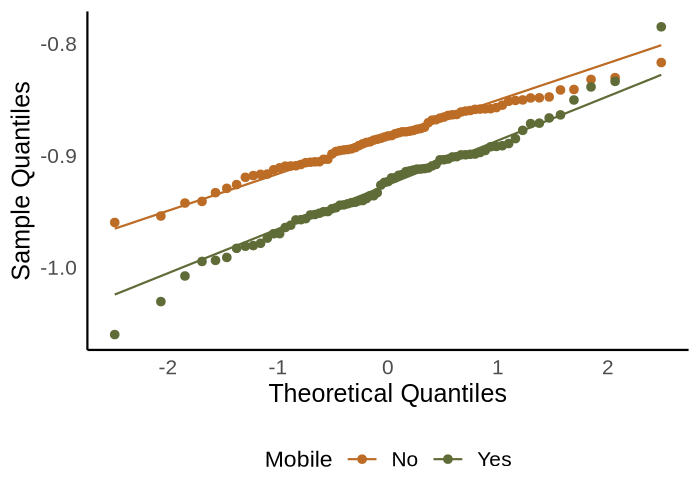

In [20]:
%%R  -w 700 -h 500 -r 150 -i df_ARG_normalized_tot

qqplot <- create_qqplot(df_ARG_normalized_tot, plot_col = "Count_normalized")
qqplot

**Figure:** Visualization for the distribution of total ARG abundance per sample. The colors represent if the ARG was found on a plasmid or not.

**Conclusion:** The data points follow the lines, indicating a normal distribution. 

Here I will perform a two tailed students t-test to test for differences in total ARG abundance.

In [21]:
def filter_df_t_test(df, day, treatment, mobile):
    """
    Return df containing the right combination of day, 
    mobile and treatment for t-test
    """
    df_tmp = df[(df.Day == day) & 
            (df.Treatment.isin([treatment, "Control"])) & 
            (df.Mobile == mobile)]
    return df_tmp

def create_df(treatment):
    """
    Mock df used to make sure that we have values for all replicates
    """
    all_replicates = pd.DataFrame({
        'Treatment': [treatment, treatment, treatment, treatment, treatment, 
                     'Control', 'Control', 'Control', 'Control', 'Control'],
        'Replicate': ["1", "2", "3", "4", "5"] * 2,

    })   
    return all_replicates

def dict_append_t_test(day, treatment, mobile, p_value):
    """
    dict with t-test statistics
    """
    result_dict = {
        'Day': day,
        'Treatment': treatment,
        'Mobile': mobile,
        'p_value': p_value
    }
    return result_dict

    
# Initialize a list to store all results
results_list = []

df_test = df_ARG_normalized_tot.copy()
# Get values to filter on
pseudo_count = df_test[df_test.Count_normalized != 0].Count_normalized.min()

list_treatments = df_test[~df_test.Treatment.isin(["Control", "Input"])].Treatment.unique()
list_days = df_test[df_test.Day != "Day 0"].Day.unique()
list_mobile = df_test.Mobile.unique()

# Perform t-test for all relevant combinations
for day in list_days:
    for treatment in list_treatments:
        for mobile in list_mobile:
            # Filter, prepare data and make sure that we have datapoints for all replicates
            df_tmp = filter_df_t_test(df_test, day, treatment, mobile)
            df_mock = create_df(treatment)
            df_tmp = pd.merge(df_mock, df_tmp, on=["Treatment", "Replicate"], how="left").fillna(0).infer_objects(copy=False)
            
            # Prepare data
            df_tmp["Count_normalized_log10"] = np.log10(df_tmp.Count_normalized + pseudo_count)
            list_treatment = df_tmp[df_tmp.Treatment == treatment].Count_normalized_log10
            list_control = df_tmp[df_tmp.Treatment == "Control"].Count_normalized_log10
            
            # perform test and append resultsto list
            t_stat, p_value = stats.ttest_rel(list_control, list_treatment, alternative = "two-sided")
            results_list.append(dict_append_t_test(day, treatment, mobile, p_value))

# Convert list of dictionaries to DataFrame
results_df_ARG_tot = pd.DataFrame(results_list)

# Add FDR-corrected p-values indicate significance
results_df_ARG_tot['FDR'] = stats.false_discovery_control(results_df_ARG_tot['p_value'])
results_df_ARG_tot["Significant"] = np.where(results_df_ARG_tot["FDR"] <= 0.05, "Yes", "No")
results_df_ARG_tot

,Day,Treatment,Mobile,p_value,FDR,Significant
0,Day 1,Ciprofloxacin 0.1,No,0.872070,0.998223,No
1,Day 1,Ciprofloxacin 0.1,Yes,0.159877,0.500019,No
2,Day 1,Ciprofloxacin 10,No,0.005990,0.119793,No
3,Day 1,Ciprofloxacin 10,Yes,0.994293,0.998223,No
4,Day 1,Tetracycline 0.05,No,0.748355,0.998223,No
5,Day 1,Tetracycline 0.05,Yes,0.885984,0.998223,No
6,Day 1,Tetracycline 0.5,No,0.072230,0.307782,No
7,Day 1,Tetracycline 0.5,Yes,0.458505,0.833646,No
8,Day 1,Tetracycline 25,No,0.970637,0.998223,No
9,Day 1,Tetracycline 25,Yes,0.998223,0.998223,No


**Table:** These are the results of a paired t-test with FDR corrected p-values.

In [22]:
%%R
###
# Function to plot count data
###
create_custom_plot <- function(data, 
                               x_var = "Treatment", 
                               y_var = "Count_normalized", 
                               facet_var = NULL,
                               break_val = 5,
                               stars = NULL,
                               facet_scales = "free",
                               facet_space = "free_x",
                               y_lab = "") {
                                 
  # Ensure Treatment is a factor with Control as the reference level
  data$Treatment<- factor(data$Treatment, 
                                        levels = c("Input", "Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                        "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))
  
  # Calculate mean and standard deviation
  summary_data <- data %>%
    group_by(across(c(all_of(x_var), all_of(facet_var)))) %>%
    summarise(
      mean_count = mean(.data[[y_var]]),
      sd_count = sd(.data[[y_var]]),
      .groups = "drop"
    )
  color_swarm <- "#5B583D"
  color_stats <- "#3D405B"
  # Base plot
  plot <- ggplot(data, aes(x = .data[[x_var]], y = .data[[y_var]])) +
    geom_beeswarm(color = color_swarm, size = 2, cex = 3, alpha = 0.6) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = "white", 
                  width = 0.4,
                  size = 0.5) +
    geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "white",
               size = 2) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = color_stats, 
                  width = 0.2,
                  size = 0.5) +
    geom_point(data = summary_data,
               aes(y = mean_count),
               colour = color_stats,
               size = 2) +
    scale_y_continuous(n.breaks = break_val) +
    theme(
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "none",
      plot.title = element_blank()
    ) +
    ylab(y_lab) +
    xlab("")
  
  # Add faceting if facet_var is provided
  if (!is.null(facet_var)) {
    plot <- plot + facet_grid(as.formula(paste("~", facet_var)), 
                              scales = facet_scales, 
                              space = facet_space)
  }
  
  # Add stars if provided
  if (!is.null(stars)) {
    for (star in stars) {
      max_y <- max(data[[y_var]][data[[x_var]] == star$x & data[[facet_var]] == star$facet])
      star_data <- data.frame(x = star$x, y = max_y * 1.1, label = "*")
      star_data[[facet_var]] <- star$facet
      
      plot <- plot +
        geom_text(data = star_data,
                  aes(x = x, y = y, label = label),
                  size = 8, color = "black")
    }
  }
  
  return(plot)
}

Here I create a count matrix where the normalized counts are converted to integers based on the smallest count exponent. I do this to create my normalized count matrix from floats to integers so I can rarefy them. Floats are converted to integers by identifying the smallest non zero value, rounding it, and then multiplying all values by 10^{the smallest value}.

In [23]:
smallest_exponent = abs(round(math.log10(df_ARG_normalized.Count_normalized.min())))
df_ARG_normalized["Count_normalized_integer"] = (df_ARG_normalized["Count_normalized"] * (10 ** smallest_exponent)).round().astype(int)

df_ARG_normalized_matrix_pl_yes = df_ARG_normalized[df_ARG_normalized.Mobile == "Yes"].pivot(index='Sample', columns='Reference', values='Count_normalized_integer').fillna(0)
df_ARG_normalized_matrix_pl_no = df_ARG_normalized[df_ARG_normalized.Mobile == "No"].pivot(index='Sample', columns='Reference', values='Count_normalized_integer').fillna(0)


In [24]:
%%R -i df_ARG_normalized_matrix_pl_yes -i df_ARG_normalized_matrix_pl_no -o combined_df_rare_arg

###
# Here I rarefy the ARGs separately based on if they were found or not found on plasmids.  
###

S <- specnumber(df_ARG_normalized_matrix_pl_yes) # observed number of species
(raremax <- min(rowSums(df_ARG_normalized_matrix_pl_yes)))
Srare_pl_yes <- rarefy(df_ARG_normalized_matrix_pl_yes, raremax)

S <- specnumber(df_ARG_normalized_matrix_pl_no) # observed number of species
(raremax <- min(rowSums(df_ARG_normalized_matrix_pl_no)))
Srare_pl_no <- rarefy(df_ARG_normalized_matrix_pl_no, raremax)

# Create dataframes for each set of results
df_yes <- data.frame(
  Sample = names(Srare_pl_yes),
  Rarefied_values = as.vector(Srare_pl_yes),
  Mobile = "Yes"
)

df_no <- data.frame(
  Sample = names(Srare_pl_no),
  Rarefied_values = as.vector(Srare_pl_no),
  Mobile = "No"
)

# Combine the dataframes
combined_df_rare_arg <- rbind(df_yes, df_no)

In [ ]:
# Apply the functions to create new columns
combined_df_rare_arg['Day'] = combined_df_rare_arg['Sample'].apply(get_day)
combined_df_rare_arg['Treatment'] = combined_df_rare_arg['Sample'].apply(get_treatment)
combined_df_rare_arg['Replicate'] = combined_df_rare_arg['Sample'].apply(get_replicate)

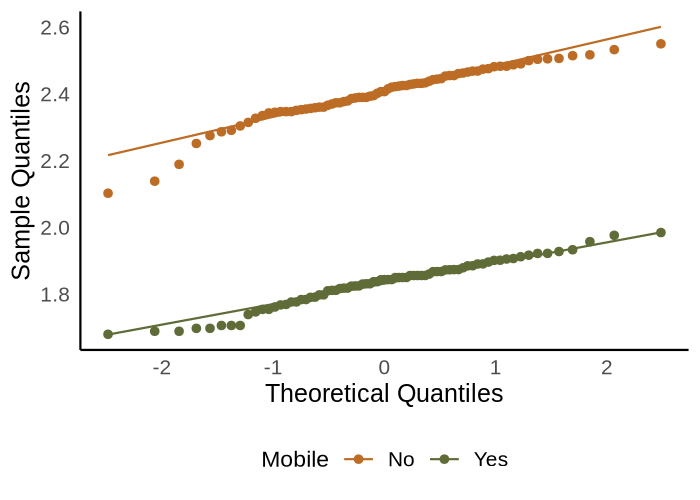

In [26]:
%%R  -w 700 -h 500 -r 150 

create_qqplot(combined_df_rare_arg, plot_col = "Rarefied_values")

**Figure:** QQ-plot showing normal distribution of rarefied ARG.

**Conclusion:** Data is normally distributed.

Here I will perform a two tailed students t-test to test for differences in rarefied ARG abundance.

In [27]:
def filter_df_t_test(df, day, treatment, mobile):
    """
    Return df containing hte right combination of day, 
    mobile and treatment for t-test
    """
    df_tmp = df[(df.Day == day) & 
            (df.Treatment.isin([treatment, "Control"])) & 
            (df.Mobile == mobile)]
    return df_tmp

def create_df(treatment):
    """
    Mock df used to make sure that we have values for all replicates
    """
    all_replicates = pd.DataFrame({
        'Treatment': [treatment, treatment, treatment, treatment, treatment, 
                     'Control', 'Control', 'Control', 'Control', 'Control'],
        'Replicate': ["1", "2", "3", "4", "5"] * 2,

    })   
    return all_replicates

def dict_append_t_test(day, treatment, mobile, p_value):
    """
    dict with t-test statistics
    """
    result_dict = {
        'Day': day,
        'Treatment': treatment,
        'Mobile': mobile,
        'p_value': p_value
    }
    return result_dict

    
# Initialize a list to store all results
results_list = []

df_test = combined_df_rare_arg.copy()
# Get values to filter on

list_treatments = df_test[~df_test.Treatment.isin(["Control", "Input"])].Treatment.unique()
list_days = df_test[df_test.Day != "Day 0"].Day.unique()
list_mobile = df_test.Mobile.unique()

# Perform t-test for all relevant combinations
for day in list_days:
    for treatment in list_treatments:
        for mobile in list_mobile:
            # Filter, prepare data and make sure that we have datapoints for all replicates
            df_tmp = filter_df_t_test(df_test, day, treatment, mobile)
            df_mock = create_df(treatment)
            df_tmp = pd.merge(df_mock, df_tmp, on=["Treatment", "Replicate"], how="left").fillna(0)
            
            # Prepare data
            df_tmp["Count_normalized_log10"] = np.log10(df_tmp.Rarefied_values )
            list_treatment = df_tmp[df_tmp.Treatment == treatment].Count_normalized_log10
            list_control = df_tmp[df_tmp.Treatment == "Control"].Count_normalized_log10
            
            # perform test and append resultsto list
            t_stat, p_value = stats.ttest_rel(list_control, list_treatment, alternative = "two-sided")
            results_list.append(dict_append_t_test(day, treatment, mobile, p_value))

# Convert list of dictionaries to DataFrame
results_df_ARG_rarefy = pd.DataFrame(results_list)

# Add FDR-corrected p-values indicate significance
results_df_ARG_rarefy['FDR'] = stats.false_discovery_control(results_df_ARG_rarefy['p_value'])
results_df_ARG_rarefy["Significant"] = np.where(results_df_ARG_rarefy["FDR"] <= 0.05, "Yes", "No")
results_df_ARG_rarefy

,Day,Treatment,Mobile,p_value,FDR,Significant
0,Day 1,Ciprofloxacin 0.1,Yes,0.053968,0.276360,No
1,Day 1,Ciprofloxacin 0.1,No,0.090266,0.276360,No
2,Day 1,Ciprofloxacin 10,Yes,0.266179,0.505357,No
3,Day 1,Ciprofloxacin 10,No,0.086116,0.276360,No
4,Day 1,Tetracycline 0.05,Yes,0.920952,0.961532,No
5,Day 1,Tetracycline 0.05,No,0.483218,0.805363,No
6,Day 1,Tetracycline 0.5,Yes,0.277946,0.505357,No
7,Day 1,Tetracycline 0.5,No,0.609618,0.931406,No
8,Day 1,Tetracycline 25,Yes,0.248028,0.505357,No
9,Day 1,Tetracycline 25,No,0.846224,0.953852,No


**Table** The output from having performed a paired t-test on rarefied ARG abundance when comparing the treated samples with the control. Shows no significant effects. 

I will not perform a paired ANOVA to test for differences in community composition.

In [28]:
%%R -i df_ARG_normalized -o ARG_permanova

# Create empty dataframe to store results
ARG_permanova <- data.frame(
  Day = character(),
  Treatment = character(),
  P_value = numeric(),
  stringsAsFactors = FALSE
)

# Get unique days and treatments
unique_days <- unique(df_ARG_normalized$Day[!df_ARG_normalized$Day %in% c("Day 0")])
unique_treatments <- unique(df_ARG_normalized$Treatment[!df_ARG_normalized$Treatment %in% c("Control", "Input")])

# Loop through each day and treatment
for (day in unique_days) {
  for (treatment in unique_treatments) {
    # Filter data for current day and only current treatment + control
    df_tmp <- df_ARG_normalized %>%
      filter(Day == day, 
             Treatment %in% c(treatment, "Control")) %>%
      pivot_wider(
        names_from = Reference,
        values_from = Count_normalized,
        id_cols = Sample
      ) %>%
      mutate(across(where(is.numeric), ~replace_na(., 0)))
    
    # Create split dataframe
    split_df <- df_tmp %>%
      select(Sample) %>%
      separate(Sample, 
               into = c("Sample", "Replicate"), 
               sep = "_(?=[^_]+$)")
    
    # Keep original df without Sample column
    original_df <- df_tmp %>%
      select(-Sample)
    
    # Perform PERMANOVA
    perm_result <- (with(split_df, 
                        adonis2(original_df ~ Sample, 
                               data = split_df, 
                               permutations = 999)))
    
    # Extract p-value and append to results
    ARG_permanova <- rbind(ARG_permanova, 
                       data.frame(
                         Day = day,
                         Treatment = treatment,
                         P_value = perm_result$`Pr(>F)`[1]
                       ))
  }
}
ARG_permanova$FDR <- p.adjust(ARG_permanova$P_value, method = "BH")

/opt/conda/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [29]:
ARG_permanova

,Day,Treatment,P_value,FDR
1,Day 1,Ciprofloxacin 0.1,0.375,0.891000
2,Day 1,Ciprofloxacin 10,0.645,0.891000
3,Day 1,Tetracycline 0.05,0.835,0.891000
4,Day 1,Tetracycline 0.5,0.873,0.891000
5,Day 1,Tetracycline 25,0.242,0.806667
6,Day 8,Ciprofloxacin 0.1,0.860,0.891000
7,Day 8,Ciprofloxacin 10,0.891,0.891000
8,Day 8,Tetracycline 0.05,0.741,0.891000
9,Day 8,Tetracycline 0.5,0.214,0.806667
10,Day 8,Tetracycline 25,0.118,0.806667


**Table** The result from performing a pairwise ANOVA on ARGs composition.

#### ARG abundance grouped by Drug Class

In [ ]:
# Sum ARG abundance across features
df_phenotype_normalized = df_ARG_normalized.groupby(["Sample", "Day", "Treatment", "Replicate", "Mobile", "Drug Class"]).Count_normalized.sum().reset_index()
df_phenotype_normalized["Drug_Class"] = df_phenotype_normalized["Drug Class"].copy()

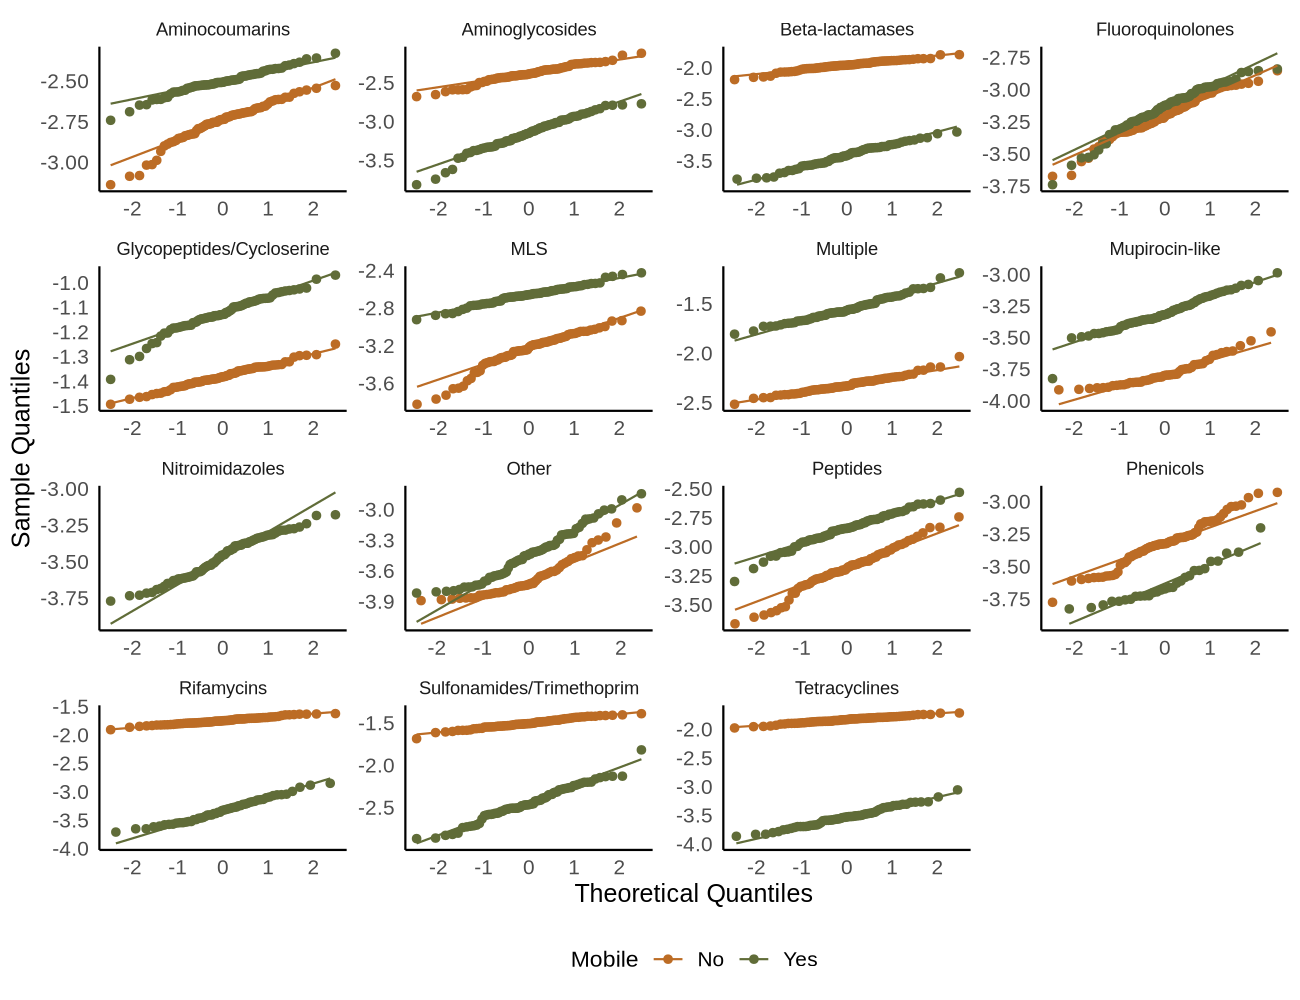

In [31]:
%%R -i df_phenotype_normalized -w 1300 -h 1000 -r 150 
qqplot <-  qqplot <- create_qqplot(df_phenotype_normalized, plot_col = "Count_normalized", facet_var="Drug_Class")
qqplot

**Figure:** distribution of ARG counts summed across phenotypes.

**Conclusion:** The data appear to be normally distributed. 

I will now perform a t-test to determine if there is a difference in drug class abundance. 

In [32]:
pd.set_option('future.no_silent_downcasting', True)
def filter_df_t_test(df, day, treatment, mobile, drug_class):
    """
    Return df containing hte right combination of day, 
    mobile and treatment for t-test
    """
    df_tmp = df[(df.Day == day) & 
            (df.Treatment.isin([treatment, "Control"])) & 
            (df.Mobile == mobile) &
            (df["Drug Class"] == drug_class)]
    return df_tmp

def create_df(treatment):
    """
    Mock df used to make sure that we have values for all replicates
    """
    all_replicates = pd.DataFrame({
        'Treatment': [treatment, treatment, treatment, treatment, treatment, 
                     'Control', 'Control', 'Control', 'Control', 'Control'],
        'Replicate': ["1", "2", "3", "4", "5"] * 2,

    })   
    return all_replicates

def dict_append_t_test(day, treatment, mobile, p_value, drug_class):
    """
    dict with t-test statistics
    """
    result_dict = {
        'Day': day,
        'Treatment': treatment,
        'Mobile': mobile,
        'Drug Class':drug_class,
        'p_value': p_value
    }
    return result_dict

    
# Initialize a list to store all results
results_list = []

df_test = df_phenotype_normalized.copy()
# Get values to filter on
pseudo_count = df_test[df_test.Count_normalized !=0].Count_normalized.min()
list_treatments = df_test[~df_test.Treatment.isin(["Control", "Input"])].Treatment.unique()
list_days = df_test[df_test.Day != "Day 0"].Day.unique()
list_mobile = df_test.Mobile.unique()
list_drug_class = df_test.Drug_Class.unique()

# Perform t-test for all relevant combinations
for day in list_days:
    for treatment in list_treatments:
        for mobile in list_mobile:
            for drug_class in list_drug_class:
                # Filter, prepare data and make sure that we have datapoints for all replicates
                df_tmp = filter_df_t_test(df_test, day, treatment, mobile, drug_class)
                df_mock = create_df(treatment)
                df_tmp = pd.merge(df_mock, df_tmp, on=["Treatment", "Replicate"], how="left").fillna(0).infer_objects(copy=False)

                # Prepare data
                df_tmp["Count_normalized_log10"] = np.log10(df_tmp.Count_normalized + pseudo_count)
                list_treatment = df_tmp[df_tmp.Treatment == treatment].Count_normalized_log10
                list_control = df_tmp[df_tmp.Treatment == "Control"].Count_normalized_log10

                # perform test and append resultsto list
                t_stat, p_value = stats.ttest_rel(list_control, list_treatment, alternative = "two-sided")
                results_list.append(dict_append_t_test(day, treatment, mobile, p_value, drug_class))

# Convert list of dictionaries to DataFrame
results_df_ARG_class = pd.DataFrame(results_list)
results_df_ARG_class['p_value'] = results_df_ARG_class['p_value'].fillna(1.0)
# Add FDR-corrected p-values indicate significance
results_df_ARG_class['FDR'] = stats.false_discovery_control(results_df_ARG_class['p_value'])
results_df_ARG_class["Significant"] = np.where(results_df_ARG_class["FDR"] <= 0.05, "Yes", "No")
results_df_ARG_class[results_df_ARG_class.Significant == "Yes"]

,Day,Treatment,Mobile,Drug Class,p_value,FDR,Significant


**Table** Here we test if there were any significant changes in the abundance of drug classes. The table only shows significant results after FDR correction. And since the table is empty there were no significant changes. 

In [33]:
%%R
###
#  Function to plot faceted ARg abundance plots.
###
create_custom_plot <- function(data, 
                               x_var = "Treatment", 
                               y_var = "Count_normalized", 
                               facet_formula = NULL,
                               break_val = 5,
                               stars = NULL,
                               facet_scales = "free",
                               facet_space = "free_x",
                               y_lab = "") {
                                 
  # Ensure Treatment is a factor with Control as the reference level
  data$Treatment <- factor(data$Treatment, 
                           levels = c("Input", "Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                      "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))
  
  # Calculate mean and standard deviation
  summary_data <- data %>%
    group_by(across(c(all_of(x_var), all_of(all.vars(facet_formula))))) %>%
    summarise(
      mean_count = mean(.data[[y_var]]),
      sd_count = sd(.data[[y_var]]),
      .groups = "drop"
    )
  
  # Base plot
  plot <- ggplot(data, aes(x = .data[[x_var]], y = .data[[y_var]])) +
    geom_beeswarm(color = "#5B583D", size = 2, cex = 3, alpha = 0.6) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = "white", 
                  width = 0.4,
                  size = 0.5) +
    geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "white",
               size = 2) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = "#3D405B", 
                  width = 0.2,
                  size = 0.5) +
    geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "#3D405B",
               size = 2) +
    scale_y_continuous(n.breaks = break_val) +
    theme(
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "none",
      plot.title = element_blank()
    ) +
    ylab(y_lab) +
    xlab("")
  
  # Add faceting if facet_formula is provided
  if (!is.null(facet_formula)) {
    plot <- plot + facet_grid(facet_formula, 
                              scales = facet_scales, 
                              space = facet_space)
  }
  
  # Add stars if provided
  if (!is.null(stars)) {
    for (star in stars) {
      facet_vars <- all.vars(facet_formula)
      facet_filter <- setNames(as.list(star$facet), facet_vars)
      max_y <- max(data[[y_var]][data[[x_var]] == star$x & 
                                   Reduce(`&`, Map(`==`, data[facet_vars], facet_filter))])
      star_data <- data.frame(x = star$x, y = max_y * 1.1, label = "*")
      star_data[facet_vars] <- facet_filter
      
      plot <- plot +
        geom_text(data = star_data,
                  aes(x = x, y = y, label = label),
                  size = 8, color = "black")
    }
  }
  
  return(plot)
}

#### Abundance of individual ARGs

Create matrices for ARG abundance divided by if found, or not found on plasmids for edgeR analysis.

In [ ]:
df_ARG_normalized_reset_index = df_ARG_normalized.reset_index()

In [35]:
# Get unique values for each category
unique_genes = df_ARG_normalized_reset_index['Reference'].unique()
unique_days = df_ARG_normalized_reset_index['Day'].unique()
unique_treatments = df_ARG_normalized_reset_index['Treatment'].unique()
unique_replicate = df_ARG_normalized_reset_index[df_ARG_normalized_reset_index.Replicate != "6"]['Replicate'].unique()

# Create all possible combinations
combinations = pd.MultiIndex.from_product(
    [unique_genes, unique_days, unique_treatments, unique_replicate],
    names=['Reference', 'Day', 'Treatment', 'Replicate']
)

# Convert to DataFrame
complete_df = pd.DataFrame(index=combinations).reset_index()

# Merge with original data
final_df = pd.merge(
    complete_df,
    df_ARG_normalized_reset_index[['Day', 'nr_16s', 'Treatment', 'Replicate', "Sample"]].drop_duplicates(),
    on=['Day', 'Treatment', 'Replicate'],
    how='left'
)

final_df = pd.merge(
    final_df.drop_duplicates(),
    df_ARG_normalized_reset_index[['Reference', 'Mobile']].drop_duplicates(),
    on=['Reference'],
    how='left'
)

final_df = pd.merge(
    final_df.drop_duplicates(),
    df_ARG_normalized_reset_index[["Reference", "Count", 'Day', 'Treatment', 'Replicate']].drop_duplicates(),
    on=['Reference', 'Day', 'Treatment', 'Replicate'],
    how='left'
)
# Fill missing values with 0
numeric_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
final_df[numeric_columns] = final_df[numeric_columns].fillna(0)

Using edgeR to investigate if the abundance of individual ARGs changed by treatments in relation to the control. 

In [36]:
%%R -i final_df -o edgeR_results_ARG

# Convert the dataframe and set factor levels
df <- data.frame(final_df)
df$Treatment <- factor(df$Treatment, 
                         levels = c("Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                    "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))

# Ensure Day is also a factor
df$Day <- factor(df$Day, levels = c("Day 1", "Day 8"))

# Define the combinations we want to test
combinations <- expand.grid(
  Day = c("Day 1", "Day 8"),
  Treatments = c("Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                  "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25")) 

# Initialize an empty list to store results
results_list <- list()

# Loop through each combination
for (i in 1:nrow(combinations)) {
  day <- as.character(combinations$Day[i])  # Convert Day to character for comparison
  treatment <- as.character(combinations$Treatments[i])  # Convert Treatment to character for comparison
  
  # Filter the data by the day and treatment (now both are characters)
  model_data_treatment <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == treatment)
  
  model_data_control <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == "Control")
  
  # Combine treatment and control data
  model_data <- rbind(model_data_control, model_data_treatment)
  
  # Reshape the data for edgeR analysis
  df_counts <- model_data %>%
    pivot_wider(names_from = Sample, values_from = Count, id_cols = Reference, values_fill = 0)
  
  sample_metadata <- model_data %>%
      select(Sample, nr_16s, Treatment, Replicate, Day) %>%
      distinct()

  # Create DGEList object
  y <- DGEList(counts = df_counts[, -1], group = sample_metadata$Treatment, lib.size = sample_metadata$nr_16s)
  # Set gene names
  rownames(y) <- df_counts$Reference
  
  # Normalize library sizes
  y <- calcNormFactors(y)
  
  # Update sample metadata in the DGEList object
  y$samples$Replicate <- factor(sample_metadata$Replicate)
  y$samples$Treatment <- factor(sample_metadata$Treatment)
  
  # Create design matrix
  design <- model.matrix(~ Treatment + Replicate, data = y$samples)
  
  # Estimate dispersion
  y <- estimateDisp(y, design)
  
  # Fit the model
  fit <- glmQLFit(y, design)
  
  # Test for differentially expressed genes
  qlf <- glmQLFTest(fit, coef = 2)
  
  # Store significant results
  df_Sig <- as.data.frame(topTags(qlf, n = Inf))
  df_Sig$Day <- day
  df_Sig$Treatment <- treatment
  # Move index to Gene column
  df_Sig <- df_Sig %>%
    tibble::rownames_to_column(var = "Gene")
  
  # Append the results to the list
  results_list <- append(results_list, list(df_Sig))
}

# Combine all results into a single dataframe
all_results <- do.call(rbind, results_list)

# Store the final results
edgeR_results_ARG <- all_results

Add metadata to edgeR analysis.

In [37]:
# Function to determine the treatment
def get_treatment_edgeR(sample):
    if 'input' in sample:
        return 'Input'
    elif 'Cip_01' in sample:
        return 'Ciprofloxacin 0.1'
    elif 'Cip_10' in sample:
        return 'Ciprofloxacin 10'
    elif 'Tet_005' in sample:
        return 'Tetracycline 0.05'
    elif 'Tet_05' in sample:
        return 'Tetracycline 0.5'
    elif 'Tet_25' in sample:
        return 'Tetracycline 25'
    elif 'Ctrl' in sample:
        return 'Control'
    else:
        return np.nan
    
def get_Day_edgeR(sample):
    if 'day1' in sample:
        return 'Day 1'
    elif 'day8' in sample:
        return 'Day 8'
    
def get_Gene(sample):
    if '|ARO:' in sample:
        return sample.split("|")[3].split("_[")[0]
    else:
        return sample.split("|")[-1]
 
edgeR_results_ARG['Gene_name'] = edgeR_results_ARG['Gene'].apply(get_Gene)

edgeR_results_ARG["FDR"] = stats.false_discovery_control(edgeR_results_ARG["PValue"])
signif_ARGS = edgeR_results_ARG[edgeR_results_ARG.FDR <= 0.05].copy()
signif_ARGS

signif_ARGS_list = signif_ARGS.Gene.unique()
signif_ARGS_df = df_ARG_normalized[df_ARG_normalized.Reference.isin(signif_ARGS_list)]
signif_ARGS_df['Gene'] = signif_ARGS_df['Reference'].apply(get_Gene)
signif_ARGS = pd.merge(signif_ARGS, df_ARG_normalized[["Reference", "Mobile", "Drug Class", "DB"]].drop_duplicates(), how = "left", left_on = "Gene", right_on="Reference")
signif_ARGS = signif_ARGS.drop(columns=['Reference'])
signif_ARGS

/tmp/ipykernel_60262/3820213199.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_ARGS_df['Gene'] = signif_ARGS_df['Reference'].apply(get_Gene)


,Gene,logFC,logCPM,F,PValue,FDR,Day,Treatment,Gene_name,Mobile,Drug Class,DB
0,gb|SIP52035.1|ARO:3004054|Paer_CpxR_[Pseudomonas_aeruginosa]_,1.788074,10.594235,29.066004,7.274583e-08,0.001045,Day 8,Tetracycline 0.5,Paer_CpxR,Yes,Multiple,CARD
1,gb|AHA41500.1|ARO:3002913|vanO_[Rhodococcus_hoagii]_,3.749569,8.307561,26.396361,2.872472e-07,0.002062,Day 8,Tetracycline 25,vanO,Yes,Glycopeptides/Cycloserine,CARD
2,gb|AHA41499.1|ARO:3002948|vanH_in_vanO_cl_[Rhodococcus_hoagii]_,3.042932,8.306878,21.539657,3.542901e-06,0.016959,Day 8,Tetracycline 25,vanH_in_vanO_cl,Yes,Glycopeptides/Cycloserine,CARD


**Table:** Here are all genes which were found ot be DE by edgeR. Since they were so few we have an excellent opportunity to investigate if these changes are biologically significant, or just statistical noise. 

In this cell I will calculate the coverage and breadth of each significant arg to further investigate if the DE changes were relevant or just noise. 

In [38]:
df_ARG_sig = pd.merge(df_ARG, df_cluster_ARG, on = "sseqid")
df_ARG_sig = df_ARG_sig[df_ARG_sig.Reference.isin(signif_ARGS_df.Reference.unique())]
df_ARG_sig = pd.merge(df_ARG_sig, df_length, on ="Reference")


# Calculate the number of bases (from reads) covering each position on the ARG.
all_coverage_data = []
# for each gene and sample
for gene in df_ARG_sig.Reference.unique():
    df_tmp = df_ARG_sig[df_ARG_sig.Reference == gene]
    for sample in df_tmp.Sample.unique():
        df_tmp_ = df_tmp[df_tmp.Sample == sample]
        
        # Crete list of 0 with the length of the gene
        # Each number represents a position in the gene
        gene_length = df_tmp_.Length.unique()[0]
        list_zero = [0] * gene_length 
        
        # For each aligned read 
        for index, row in df_tmp_.iterrows():
            start = row.sstart
            end = row.send
            positional_scores = range(start, end)
            # add number of nucleotides mapped
            for score in positional_scores:
                list_zero[score] += 1
        
        # Create coverage data for this gene and sample
        for position, coverage in enumerate(list_zero, start=1):  # start=1 for 1-based position
            all_coverage_data.append({
                'position': position,
                'coverage': coverage,
                'Gene': gene,
                'Sample': sample
            })

# Create the final DataFrame
coverage_df_arg = pd.DataFrame(all_coverage_data)

# Calculate statistics
stats_df = coverage_df_arg.groupby(['Gene', 'Sample']).agg(
    total_positions=('coverage', 'count'),
    positions_above_zero=('coverage', lambda x: (x > 0).sum()),
    median_coverage=('coverage', 'median'),
    mean_coverage=('coverage', 'mean'),
    min_coverage=('coverage', 'min'),
    max_coverage=('coverage', 'max')
)

# Calculate percentage of positions above zero
stats_df['percent_above_zero'] = (stats_df['positions_above_zero'] / stats_df['total_positions']) * 100

# Reorder columns for clarity
stats_df = stats_df[['total_positions', 'positions_above_zero', 'percent_above_zero', 'median_coverage', 'mean_coverage', 'min_coverage', 'max_coverage']]

# Reset index to make chosen_template and file_name regular columns
stats_df = stats_df.reset_index()

# Add sample metadata
def get_treatment(sample):
    if 'input' in sample:
        return 'Input'
    elif 'Cip_0.1' in sample:
        return 'Ciprofloxacin 0.1'
    elif 'Cip_10' in sample:
        return 'Ciprofloxacin 10'
    elif 'Tet_0.05' in sample:
        return 'Tetracycline 0.05'
    elif 'Tet_0.5' in sample:
        return 'Tetracycline 0.5'
    elif 'Tet_25' in sample:
        return 'Tetracycline 25'
    elif 'Ctrl' in sample:
        return 'Control'
    else:
        return np.nan
    
# Add sample metadata   
def get_Day(sample):
    if '1d' in sample:
        return 'Day 1'
    elif '8d' in sample:
        return 'Day 8'
    
# Add sample metadata   
def get_Gene(sample):
    if '|ARO:' in sample:
        return sample.split("|")[3].split("_[")[0]
    else:
        return sample.split("|")[-1]

# Call metadata functions for overview statistics
stats_df['Treatment_clean'] = stats_df['Sample'].apply(get_treatment)
stats_df['Day'] = stats_df['Sample'].apply(get_Day)
stats_df['Gene_name'] = stats_df['Gene'].apply(get_Gene)

# Call metadata functions for raw coveragedata
coverage_df_arg['Treatment_clean'] = coverage_df_arg['Sample'].apply(get_treatment)
coverage_df_arg['Day'] = coverage_df_arg['Sample'].apply(get_Day)
coverage_df_arg['Gene_name'] = coverage_df_arg['Gene'].apply(get_Gene)
coverage_df_arg["Replicate"] = coverage_df_arg.Sample.str.split("_").str[-1]

#### Mumame mutation analysis 

Prepare data for edgeR.

In [39]:
# Pivot mumame data
df_mumame_normalized_piv = df_mumame_normalized.pivot(index='Mutation', columns='Sample', values="Count").fillna(0)

# Extract mtadata
df_mumame_metadata = df_mumame_normalized[["Sample", "nr_16s", "Day", "Treatment", "Replicate"]].drop_duplicates()
df_mumame_metadata["Groups"] = df_mumame_metadata["Day"].str.replace(" ", "_") + "_" + df_mumame_metadata["Treatment"].str.replace(" ", "_") 

Using edgeR to investigate if the abundance of individual mutations changed by treatments in relation to the control.

In [40]:
%%R -i df_mumame_normalized -o edgeR_results_mutations

# Convert the dataframe and set factor levels
df <- data.frame(df_mumame_normalized)
df$Treatment <- factor(df$Treatment, 
                         levels = c("Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                    "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))

# Ensure Day is also a factor
df$Day <- factor(df$Day, levels = c("Day 1", "Day 8"))

# Define the combinations we want to test
combinations <- expand.grid(
  Day = c("Day 1", "Day 8"),
  Treatments = c("Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                  "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25")) 

# Initialize an empty list to store results
results_list <- list()

# Loop through each combination
for (i in 1:nrow(combinations)) {
  day <- as.character(combinations$Day[i])  # Convert Day to character for comparison
  treatment <- as.character(combinations$Treatments[i])  # Convert Treatment to character for comparison
  
  # Filter the data by the day and treatment (now both are characters)
  model_data_treatment <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == treatment)
  
  model_data_control <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == "Control")
  
  # Combine treatment and control data
  model_data <- rbind(model_data_control, model_data_treatment)
  
  # Reshape the data for edgeR analysis
  df_counts <- model_data %>%
    pivot_wider(names_from = Sample, values_from = Count, id_cols = Mutation, values_fill = 0)
  
  sample_metadata <- model_data %>%
      select(Sample, nr_16s, Treatment, Replicate, Day) %>%
      distinct()

  # Create DGEList object
  y <- DGEList(counts = df_counts[, -1], group = sample_metadata$Treatment, lib.size = sample_metadata$nr_16s)
  
  # Set gene names
  rownames(y) <- df_counts$Mutation
  
  # Normalize library sizes
  y <- calcNormFactors(y)
  
  # Update sample metadata in the DGEList object
  y$samples$Replicate <- factor(sample_metadata$Replicate)
  y$samples$Treatment <- factor(sample_metadata$Treatment)
  
  # Create design matrix
  design <- model.matrix(~ Treatment + Replicate, data = y$samples)
  
  # Estimate dispersion
  y <- estimateDisp(y, design)
  
  # Fit the model
  fit <- glmQLFit(y, design)
  glm
  # Test for differentially expressed genes
  qlf <- glmQLFTest(fit, coef = 2)
  
  # Store significant results
  df_Sig <- as.data.frame(topTags(qlf, n = Inf))
  df_Sig$Day <- day
  df_Sig$Treatment <- treatment
  # Move index to Gene column
  df_Sig <- df_Sig %>%
    tibble::rownames_to_column(var = "Mutation")
  
  # Append the results to the list
  results_list <- append(results_list, list(df_Sig))
}

# Combine all results into a single dataframe
all_results <- do.call(rbind, results_list)

# Store the final results
edgeR_results_mutations <- all_results

Add metadata and filter mumame edgeR results.

In [41]:
edgeR_results_mutations["FDR"] = stats.false_discovery_control(edgeR_results_mutations["PValue"])
edgeR_results_mutations_sig = edgeR_results_mutations[edgeR_results_mutations.FDR <= 0.05].copy()
edgeR_results_mutations_sig

,Mutation,logFC,logCPM,F,PValue,FDR,Day,Treatment


**Table:** This "table" contains all significant mutations after the edgeR analysis. 

**Conclusion:** There were no significant DE mutations. 

### MGE

In [ ]:
# Add gene name
df_MGE_normalized["Gene"] = df_MGE_normalized.Reference.str.split("|").str[1]
# Sum abundance per MGE class or name
df_MGE_class = df_MGE_normalized.groupby(["Sample", "Type", "Day", "Treatment","Replicate"]).Count_normalized.sum().reset_index()
df_MGE_gene = df_MGE_normalized.groupby(["Sample", "Gene", "Day", "Treatment","Replicate", "nr_16s"]).Count.sum().reset_index()
# Some gene names do not have gene names
df_MGE_gene = df_MGE_gene[df_MGE_gene.Gene != "NA"]
# Harmonize names to ARG df
df_MGE_gene["Reference"] = df_MGE_gene["Gene"].copy()

Perform t-test

In [43]:
def filter_df_t_test(df, day, treatment, Type):
    """
    Return df containing hte right combination of day, 
    MGE class and treatment for t-test
    """
    df_tmp = df[(df.Day == day) & 
            (df.Treatment.isin([treatment, "Control"])) & 
            (df.Type == Type)]
    return df_tmp

def create_df(treatment):
    """
    Mock df used to make sure that we have values for all replicates
    """
    all_replicates = pd.DataFrame({
        'Treatment': [treatment, treatment, treatment, treatment, treatment, 
                     'Control', 'Control', 'Control', 'Control', 'Control'],
        'Replicate': ["1", "2", "3", "4", "5"] * 2,

    })   
    return all_replicates

def dict_append_t_test(day, treatment, Type, p_value):
    """
    dict with t-test statistics
    """
    result_dict = {
        'Day': day,
        'Treatment': treatment,
        'Type': Type,
        'p_value': p_value
    }
    return result_dict

    
# Initialize a list to store all results
results_list = []

df_test = df_MGE_class.copy()
# Get values to filter on

list_treatments = df_test[~df_test.Treatment.isin(["Control", "Input"])].Treatment.unique()
list_days = df_test[df_test.Day != "Day 0"].Day.unique()
list_Type = df_test.Type.unique()
pseudo_count = df_test[df_test.Count_normalized != "Day 0"].Count_normalized.min()
# Perform t-test for all relevant combinations
for day in list_days:
    for treatment in list_treatments:
        for Type in list_Type:
            # Filter, prepare data and make sure that we have datapoints for all replicates
            df_tmp = filter_df_t_test(df_test, day, treatment, Type)
            df_mock = create_df(treatment)
            df_tmp = pd.merge(df_mock, df_tmp, on=["Treatment", "Replicate"], how="left").fillna(0)
            
            # Prepare data
            df_tmp["Count_normalized_log10"] = np.log10(df_tmp.Count_normalized +  pseudo_count)
            list_treatment = df_tmp[df_tmp.Treatment == treatment].Count_normalized_log10
            list_control = df_tmp[df_tmp.Treatment == "Control"].Count_normalized_log10
            
            # perform test and append resultsto list
            t_stat, p_value = stats.ttest_rel(list_control, list_treatment, alternative = "two-sided")
            results_list.append(dict_append_t_test(day, treatment, Type, p_value))

# Convert list of dictionaries to DataFrame
results_df_MGE = pd.DataFrame(results_list)

# Add FDR-corrected p-values indicate significance
results_df_MGE['FDR'] = stats.false_discovery_control(results_df_MGE['p_value'])
results_df_MGE["Significant"] = np.where(results_df_MGE["FDR"] <= 0.05, "Yes", "No")
results_df_MGE

,Day,Treatment,Type,p_value,FDR,Significant
0,Day 1,Ciprofloxacin 0.1,Conjugation,0.579375,0.881953,No
1,Day 1,Ciprofloxacin 0.1,IS elements,0.099269,0.554970,No
2,Day 1,Ciprofloxacin 0.1,Integrases,0.129493,0.554970,No
3,Day 1,Ciprofloxacin 10,Conjugation,0.103427,0.554970,No
4,Day 1,Ciprofloxacin 10,IS elements,0.047638,0.554970,No
5,Day 1,Ciprofloxacin 10,Integrases,0.982618,0.982618,No
6,Day 1,Tetracycline 0.05,Conjugation,0.482868,0.881953,No
7,Day 1,Tetracycline 0.05,IS elements,0.851461,0.954086,No
8,Day 1,Tetracycline 0.05,Integrases,0.558640,0.881953,No
9,Day 1,Tetracycline 0.5,Conjugation,0.537454,0.881953,No


**Table** Here is the output from performing a paired two tailed t-test on the MGE class abundance between the treated samples and the controls. 

Using edgeR to investigate if the abundance of individual MGEs changed by treatments in relation to the control.

In [44]:
%%R -i df_MGE_gene -o edgeR_results_MGE
# 

# Convert the dataframe and set factor levels
df <- data.frame(df_MGE_gene)
df$Treatment <- factor(df$Treatment, 
                         levels = c("Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                    "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))

# Ensure Day is also a factor
df$Day <- factor(df$Day, levels = c("Day 1", "Day 8"))

# Define the combinations we want to test
combinations <- expand.grid(
  Day = c("Day 1", "Day 8"),
  Treatments = c("Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                  "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25")) 

# Initialize an empty list to store results
results_list <- list()

# Loop through each combination
for (i in 1:nrow(combinations)) {
  day <- as.character(combinations$Day[i])  # Convert Day to character for comparison
  treatment <- as.character(combinations$Treatments[i])  # Convert Treatment to character for comparison
  
  # Filter the data by the day and treatment (now both are characters)
  model_data_treatment <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == treatment)
  
  model_data_control <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == "Control")
  
  # Combine treatment and control data
  model_data <- rbind(model_data_control, model_data_treatment)
  
  # Reshape the data for edgeR analysis
  df_counts <- model_data %>%
    pivot_wider(names_from = Sample, values_from = Count, id_cols = Reference, values_fill = 0)
  
  sample_metadata <- model_data %>%
      select(Sample, nr_16s, Treatment, Replicate, Day) %>%
      distinct()

  # Create DGEList object
  y <- DGEList(counts = df_counts[, -1], group = sample_metadata$Treatment, lib.size = sample_metadata$nr_16s)
  
  # Set gene names
  rownames(y) <- df_counts$Reference
  
  # Normalize library sizes
  y <- calcNormFactors(y)
  
  # Update sample metadata in the DGEList object
  y$samples$Replicate <- factor(sample_metadata$Replicate)
  y$samples$Treatment <- factor(sample_metadata$Treatment)
  
  # Create design matrix
  design <- model.matrix(~ Treatment + Replicate, data = y$samples)
  
  # Estimate dispersion
  y <- estimateDisp(y, design)
  
  # Fit the model
  fit <- glmQLFit(y, design)
  
  # Test for differentially expressed genes
  qlf <- glmQLFTest(fit, coef = 2)
  
  # Store significant results
  df_Sig <- as.data.frame(topTags(qlf, n = Inf))
  df_Sig$Day <- day
  df_Sig$Treatment <- treatment
  # Move index to Gene column
  df_Sig <- df_Sig %>%
    tibble::rownames_to_column(var = "Gene")
  
  # Append the results to the list
  results_list <- append(results_list, list(df_Sig))
}

# Combine all results into a single dataframe
all_results <- do.call(rbind, results_list)

# Store the final results
edgeR_results_MGE <- all_results

In [45]:
edgeR_results_MGE[edgeR_results_MGE.FDR <= 0.05]

,Gene,logFC,logCPM,F,PValue,FDR,Day,Treatment
1,Bmul_0189,3.251801,11.293381,93.065425,1.077866e-19,9.485223e-18,Day 1,Ciprofloxacin 0.1
179,Bmul_0189,3.844352,12.038324,160.743333,1.338758e-30,1.178107e-28,Day 1,Ciprofloxacin 10
358,Bmul_0189,-1.977085,8.754437,16.655184,5.477411e-05,5.148767e-03,Day 1,Tetracycline 0.05
359,istA,0.756029,10.225894,12.691506,4.145439e-04,1.948356e-02,Day 1,Tetracycline 0.05
452,istA,0.857649,11.565481,16.145740,7.072212e-05,6.718602e-03,Day 8,Tetracycline 0.05
547,Bmul_0189,-2.252022,8.698149,18.321163,2.383279e-05,2.192617e-03,Day 1,Tetracycline 0.5
639,istA,1.494130,12.199786,36.530681,3.653776e-09,3.398012e-07,Day 8,Tetracycline 0.5
824,istA,-1.245032,10.565787,28.070204,2.030772e-07,1.848003e-05,Day 8,Tetracycline 25


In this cell I will calculate the coverage and breadth of each significant MGE to further investigate if the DE changes were relevant or just noise. 

In [46]:
edgeR_results_MGE["FDR"] = stats.false_discovery_control(edgeR_results_MGE["PValue"])
mge_signif = edgeR_results_MGE[edgeR_results_MGE.FDR <= 0.05]

# Prepare input data
df_MGE_sig = pd.merge(df_MGE, df_cluster_MGE, on = "sseqid")
df_MGE_sig["Gene"] = df_MGE_sig.Reference.str.split("|").str[1]
df_MGE_sig = df_MGE_sig[df_MGE_sig.Gene.isin(mge_signif.Gene.unique())]
df_MGE_sig = pd.merge(df_MGE_sig, df_length, on ="Reference")


# Calculate the number of bases (from reads) covering each position on the ARG.
all_coverage_data = []
# for each gene and sample
for gene in df_MGE_sig.Reference.unique():
    df_tmp = df_MGE_sig[df_MGE_sig.Reference == gene]
    for sample in df_tmp.Sample.unique():
        df_tmp_ = df_tmp[df_tmp.Sample == sample]
        
        # Crete list of 0 with the length of the gene
        # Each number represents a position in the gene
        gene_length = df_tmp_.Length.unique()[0]
        list_zero = [0] * gene_length 
        
        # For each aligned read 
        for index, row in df_tmp_.iterrows():
            start = row.sstart
            end = row.send
            positional_scores = range(start, end)
            # add number of nucleotides mapped
            for score in positional_scores:
                list_zero[score] += 1
        
        # Create coverage data for this gene and sample
        for position, coverage in enumerate(list_zero, start=1):  # start=1 for 1-based position
            all_coverage_data.append({
                'position': position,
                'coverage': coverage,
                'Gene': gene,
                'Sample': sample
            })

# Create the final DataFrame
coverage_df_mge = pd.DataFrame(all_coverage_data)

# Calculate statistics
stats_df_mge = coverage_df_arg.groupby(['Gene', 'Sample']).agg(
    total_positions=('coverage', 'count'),
    positions_above_zero=('coverage', lambda x: (x > 0).sum()),
    median_coverage=('coverage', 'median'),
    mean_coverage=('coverage', 'mean'),
    min_coverage=('coverage', 'min'),
    max_coverage=('coverage', 'max')
)

# Calculate percentage of positions above zero
stats_df_mge['percent_above_zero'] = (stats_df_mge['positions_above_zero'] / stats_df_mge['total_positions']) * 100

# Reorder columns for clarity
stats_df_mge = stats_df_mge[['total_positions', 'positions_above_zero', 'percent_above_zero', 'median_coverage', 'mean_coverage', 'min_coverage', 'max_coverage']]

# Reset index to make chosen_template and file_name regular columns
stats_df_mge = stats_df_mge.reset_index()

# Add sample metadata
def get_treatment(sample):
    if 'input' in sample:
        return 'Input'
    elif 'Cip_0.1' in sample:
        return 'Ciprofloxacin 0.1'
    elif 'Cip_10' in sample:
        return 'Ciprofloxacin 10'
    elif 'Tet_0.05' in sample:
        return 'Tetracycline 0.05'
    elif 'Tet_0.5' in sample:
        return 'Tetracycline 0.5'
    elif 'Tet_25' in sample:
        return 'Tetracycline 25'
    elif 'Ctrl' in sample:
        return 'Control'
    else:
        return np.nan
    
# Add sample metadata   
def get_Day(sample):
    if '1d' in sample:
        return 'Day 1'
    elif '8d' in sample:
        return 'Day 8'
    
# Add sample metadata   
def get_Gene(sample):
    return sample.split("|")[1]

# Call metadata functions for overview statistics
stats_df_mge['Treatment_clean'] = stats_df_mge['Sample'].apply(get_treatment)
stats_df_mge['Day'] = stats_df_mge['Sample'].apply(get_Day)
stats_df_mge['Gene_name'] = stats_df_mge['Gene'].apply(get_Gene)

# Call metadata functions for raw coveragedata
coverage_df_mge['Treatment_clean'] = coverage_df_mge['Sample'].apply(get_treatment)
coverage_df_mge['Day'] = coverage_df_mge['Sample'].apply(get_Day)
coverage_df_mge['Gene_name'] = coverage_df_mge['Gene'].apply(get_Gene)
coverage_df_mge["Replicate"] = coverage_df_mge.Sample.str.split("_").str[-1]
coverage_df_mge = coverage_df_mge.groupby(["position", "Gene", "Sample", "Treatment_clean", "Day", "Gene_name", "Replicate"]).coverage.sum().reset_index()
coverage_df_mge_median = coverage_df_mge.groupby(["Gene", "Sample", "Treatment_clean", "Day", "Gene_name", "Replicate"]).coverage.median().reset_index(name="Median_coverage")
coverage_df_mge_median_ssigniff = coverage_df_mge_median[coverage_df_mge_median.Gene_name.isin(mge_signif.Gene.unique())]

In order to keep a significant hit it has to had a median coverage above at least one in at least 3/5 replicate in the treatment where it was highest. Lets say that a gene decreased in abundance in cip 10 in relation to the control. Then the gene need to have a median coverage above one in 3/5 replicates in the control, but **NOT** cip 10. 

In [ ]:
# Calculate samples above threshold for each group
coverage_counts = (coverage_df_mge_median_ssigniff[coverage_df_mge_median_ssigniff['Median_coverage'] >= 1]
                  .groupby(['Treatment_clean', 'Day', 'Gene_name'])
                  .size()
                  .reset_index(name='Samples_above_threshold'))

# Rename Treatment_clean to Treatment for merging
coverage_counts = coverage_counts.rename(columns={'Treatment_clean': 'Treatment'})
coverage_counts = coverage_counts.rename(columns={'Gene_name': 'Gene'})

# Merge the dataframes
merged_df = mge_signif.merge(coverage_counts, 
                              on=['Treatment', 'Day', 'Gene'], 
                              how='left')

# Fill NaN values with 0 for cases where there was no coverage data
merged_df['Samples_above_threshold'] = merged_df['Samples_above_threshold'].fillna(0)

# Filter for rows with more than 2 samples above threshold
filtered_df = merged_df[merged_df['Samples_above_threshold'] > 3]
filtered_df

,Gene,logFC,logCPM,F,PValue,FDR,Day,Treatment,Samples_above_threshold
0,Bmul_0189,3.251801,11.293381,93.065425,1.077866e-19,4.925849e-17,Day 1,Ciprofloxacin 0.1,4.0
1,Bmul_0189,3.844352,12.038324,160.743333,1.338758e-30,1.223625e-27,Day 1,Ciprofloxacin 10,5.0
4,istA,0.857649,11.565481,16.145740,7.072212e-05,9.234289e-03,Day 8,Tetracycline 0.05,5.0


These are the MGEs which were significant and had a median abundance above 1 in at least three replicates.

### Taxonomy analysis

First I need to extract metadata. 

In [48]:
# Extract genera and remove rows which did not go that far down taxonomically
df_genera["Genera"] = df_genera["Taxa"].str.split(";").str[5]
df_genera = df_genera[df_genera.Genera != ""]
df_genera_clean = df_genera[df_genera['Genera'].notna() & (df_genera['Genera'] != '')].copy()

# Apply the functions to create new columns
df_genera_clean.loc[:, 'Day'] = df_genera_clean['Sample'].apply(get_day)
df_genera_clean.loc[:, 'Treatment'] = df_genera_clean['Sample'].apply(get_treatment)
df_genera_clean.loc[:, 'Replicate'] = df_genera_clean['Sample'].apply(get_replicate)

In [49]:
# Convert long df to matrix
df_genera_matrix = df_genera.pivot(index='Sample', columns='Taxa', values='nr_16s').fillna(0)

Here I rarefy genera abundance.

In [50]:
%%R -i df_genera_matrix -o df_rare_genera

S <- specnumber(df_genera_matrix) # observed number of species
(raremax <- min(rowSums(df_genera_matrix)))
Srare <- rarefy(df_genera_matrix, raremax)
#
## Create dataframes for each set of results
df_rare_genera <- data.frame(
  Sample = names(Srare),
  Rarefied_values = as.vector(Srare)
)

In [51]:
# Apply the functions to create new metadata columns
df_rare_genera['Day'] = df_rare_genera['Sample'].apply(get_day)
df_rare_genera['Treatment'] = df_rare_genera['Sample'].apply(get_treatment)
df_rare_genera['Replicate'] = df_rare_genera['Sample'].apply(get_replicate)

Plot QQ-plot of species richness

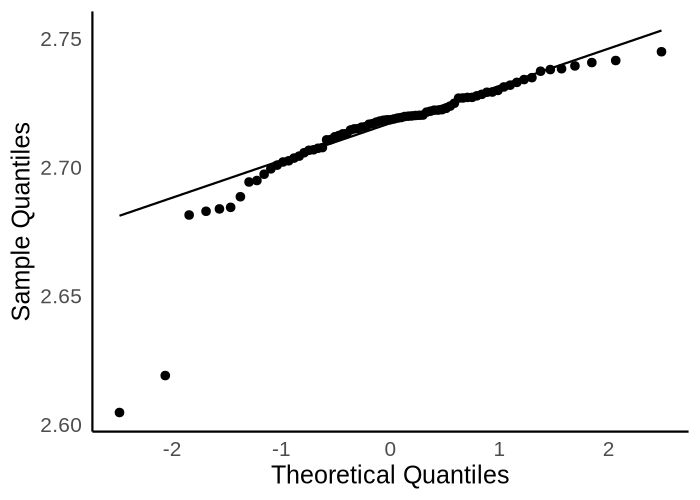

In [52]:
%%R  -w 700 -h 500 -r 150 -i df_rare_genera

# Create the base plot
p <- ggplot(df_rare_genera, aes(sample = log10(Rarefied_values))) +
    stat_qq() + 
    stat_qq_line() +
    labs(x = "Theoretical Quantiles", y = "Sample Quantiles") +
    theme_minimal() +
    theme(
      legend.position = "bottom",
      axis.title = element_text(size = 12),
      axis.text = element_text(size = 10),
      legend.text = element_text(size = 10),
      axis.line = element_line(colour = "black"),
      panel.border = element_blank(),
      panel.background = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      axis.line.x = element_line(colour = "black"),
      axis.line.y = element_line(colour = "black")
    )
p

**Figure:** This QQ-plot of the distribution of species counts indicate that the data is mostly normally distributed.

Nest, perform t-test for genera abundance.

In [53]:
def filter_df_t_test(df, day, treatment):
    """
    Return df containing hte right combination of day, 
    MGE class and treatment for t-test
    """
    df_tmp = df[(df.Day == day) & 
            (df.Treatment.isin([treatment, "Control"]))]
    return df_tmp

def create_df(treatment):
    """
    Mock df used to make sure that we have values for all replicates
    """
    all_replicates = pd.DataFrame({
        'Treatment': [treatment, treatment, treatment, treatment, treatment, 
                     'Control', 'Control', 'Control', 'Control', 'Control'],
        'Replicate': ["1", "2", "3", "4", "5"] * 2,

    })   
    return all_replicates

def dict_append_t_test(day, treatment, p_value):
    """
    dict with t-test statistics
    """
    result_dict = {
        'Day': day,
        'Treatment': treatment,
        'p_value': p_value
    }
    return result_dict

    
# Initialize a list to store all results
results_list = []

df_test = df_rare_genera.copy()
# Get values to filter on

list_treatments = df_test[~df_test.Treatment.isin(["Control", "Input"])].Treatment.unique()
list_days = df_test[df_test.Day != "Day 0"].Day.unique()

# Perform t-test for all relevant combinations
for day in list_days:
    for treatment in list_treatments:
        # Filter, prepare data and make sure that we have datapoints for all replicates
        df_tmp = filter_df_t_test(df_test, day, treatment)
        df_mock = create_df(treatment)
        df_tmp = pd.merge(df_mock, df_tmp, on=["Treatment", "Replicate"], how="left").fillna(0)
        
        # Prepare data
        df_tmp["Count_normalized_log10"] = np.log10(df_tmp.Rarefied_values)
        list_treatment = df_tmp[df_tmp.Treatment == treatment].Count_normalized_log10
        list_control = df_tmp[df_tmp.Treatment == "Control"].Count_normalized_log10
        
        # perform test and append resultsto list
        t_stat, p_value = stats.ttest_rel(list_control, list_treatment, alternative = "two-sided")
        results_list.append(dict_append_t_test(day, treatment, p_value))

# Convert list of dictionaries to DataFrame
results_df_MGE = pd.DataFrame(results_list)

# Add FDR-corrected p-values indicate significance
results_df_MGE['FDR'] = stats.false_discovery_control(results_df_MGE['p_value'])
results_df_MGE["Significant"] = np.where(results_df_MGE["FDR"] <= 0.05, "Yes", "No")
results_df_MGE

,Day,Treatment,p_value,FDR,Significant
0,Day 1,Ciprofloxacin 0.1,0.217785,0.725948,No
1,Day 1,Ciprofloxacin 10,0.181903,0.725948,No
2,Day 1,Tetracycline 0.05,0.634870,0.793588,No
3,Day 1,Tetracycline 0.5,0.295727,0.739318,No
4,Day 1,Tetracycline 25,0.630487,0.793588,No
5,Day 8,Ciprofloxacin 0.1,0.821534,0.912816,No
6,Day 8,Ciprofloxacin 10,0.954667,0.954667,No
7,Day 8,Tetracycline 0.05,0.598469,0.793588,No
8,Day 8,Tetracycline 0.5,0.006404,0.064037,No
9,Day 8,Tetracycline 25,0.463408,0.793588,No


**Table:** t-test results on the number of rarefied genera in a treated sample vs control. 

**Figure:** Rarefied genus richness across treatments.

**Conclusion:** The treatments had no major effect.

Prepare data for edgeR to test for differences in abundance of individual genera.

In [54]:
Sample_metadata_taxonomy = df_rare_genera[["Sample", "Day", "Treatment", "Replicate"]].copy().drop_duplicates()
Sample_metadata_taxonomy["Groups"] = Sample_metadata_taxonomy["Day"].str.replace(" ", "_") + "_" + Sample_metadata_taxonomy["Treatment"].str.replace(" ", "_") 

df_genera = pd.merge(df_genera, df_rare_genera[["Sample", "Day", "Treatment", "Replicate"]], on ="Sample")


# Convert long df to matrix
df_genera_matrix_edgeR = df_genera.pivot(index='Taxa', columns='Sample', values='nr_16s').fillna(0)

In [55]:
# Convert long df to matrix
df_genera_matrix_edgeR_short = df_genera[df_genera.Treatment.isin(["Control", "Input"])].pivot(index='Taxa', columns='Sample', values='nr_16s').fillna(0)
Sample_metadata_taxonomy_short = df_genera[df_genera.Treatment.isin(["Control", "Input"])][["Sample", "Day", "Treatment", "Replicate"]].drop_duplicates()

In [56]:
%%R -i df_genera  -o edgeR_results_genus

# Convert the dataframe and set factor levels
df <- data.frame(df_genera)
df$Treatment <- factor(df$Treatment, 
                         levels = c("Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                    "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))

# Ensure Day is also a factor
df$Day <- factor(df$Day, levels = c("Day 1", "Day 8"))

# Define the combinations we want to test
combinations <- expand.grid(
  Day = c("Day 1", "Day 8"),
  Treatments = c("Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                  "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25")) 

# Initialize an empty list to store results
results_list <- list()

# Loop through each combination
for (i in 1:nrow(combinations)) {
  day <- as.character(combinations$Day[i])  # Convert Day to character for comparison
  treatment <- as.character(combinations$Treatments[i])  # Convert Treatment to character for comparison
  
  # Filter the data by the day and treatment (now both are characters)
  model_data_treatment <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == treatment)
  
  model_data_control <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == "Control")
  
  # Combine treatment and control data
  model_data <- rbind(model_data_control, model_data_treatment)
  
  # Reshape the data for edgeR analysis
  df_counts <- model_data %>%
    pivot_wider(names_from = Sample, values_from = nr_16s, id_cols = Taxa, values_fill = 0)
  
  sample_metadata <- model_data %>%
      select(Sample, Treatment, Replicate, Day) %>%
      distinct()

  # Create DGEList object
  y <- DGEList(counts = df_counts[, -1], group = sample_metadata$Treatment)
  
  
  # Set gene names
  rownames(y) <- df_counts$Taxa
  
  # Normalize library sizes
  y <- calcNormFactors(y)
  
  # Update sample metadata in the DGEList object
  y$samples$Replicate <- factor(sample_metadata$Replicate)
  y$samples$Treatment <- factor(sample_metadata$Treatment)
  
  # Create design matrix
  design <- model.matrix(~ Treatment + Replicate, data = y$samples)
  
  # Estimate dispersion
  y <- estimateDisp(y, design)
  
  # Fit the model
  fit <- glmQLFit(y, design)
  
  # Test for differentially expressed genes
  qlf <- glmQLFTest(fit, coef = 2)
  
  # Store significant results
  df_Sig <- as.data.frame(topTags(qlf, n = Inf))
  df_Sig$Day <- day
  df_Sig$Treatment <- treatment
  # Move index to Gene column
  df_Sig <- df_Sig %>%
    tibble::rownames_to_column(var = "Taxa")
  
  # Append the results to the list
  results_list <- append(results_list, list(df_Sig))
}

# Combine all results into a single dataframe
all_results <- do.call(rbind, results_list)

# Store the final results
edgeR_results_genus <- all_results

In [57]:

# Add metadata to edgeR results
edgeR_results_genus["FDR"] = stats.false_discovery_control(edgeR_results_genus["PValue"])
edgeR_results_genus_sig = edgeR_results_genus[edgeR_results_genus.FDR <= 0.05].copy()

# These columns will be used to merge count data on
edgeR_results_genus_sig['comb'] = edgeR_results_genus_sig['Treatment'] + edgeR_results_genus_sig['Day'] + edgeR_results_genus_sig['Taxa']
edgeR_results_genus_sig['Comb_control'] = edgeR_results_genus_sig['Day'] + edgeR_results_genus_sig['Taxa']

## Add genus name
edgeR_results_genus_sig["Genera"] = edgeR_results_genus_sig["Taxa"].str.split(";").str[-1]

## Add metadata to df_genera
df_genera = df_genera.copy()  # Create a copy to avoid SettingWithCopyWarning

## These columns will be used to merge count data on
df_genera['comb'] = df_genera['Treatment'] + df_genera['Day'] + df_genera['Taxa']
df_genera['Comb_control'] = df_genera['Day'] + df_genera['Taxa']

## Get significant combos
edgeR_results_genus_sig_list = edgeR_results_genus_sig['comb'].unique()
edgeR_results_genus_sig_list_control = edgeR_results_genus_sig['Comb_control'].unique()

## Filter df_genera for significant combinations
df_genera_edger_sig = df_genera[df_genera['comb'].isin(edgeR_results_genus_sig_list)].copy()

## Process control data
df_genera_control = df_genera[df_genera['Treatment'] == "Control"].copy()
df_genera_control['Comb_control'] = df_genera_control['Day'] + df_genera_control['Taxa']
df_genera_control = df_genera_control[df_genera_control['Comb_control'].isin(edgeR_results_genus_sig_list_control)]

## Combine significant and control data
df_genera_control_comb = pd.concat([df_genera_control, df_genera_edger_sig])

## Add genus name and edgeR metadata
df_genera_control_comb["Genera"] = df_genera_control_comb["Taxa"].str.split(";").str[-1]

Here I add metadata to the edgeR results, as well as to create a df with the abundance of each genus.

In [58]:
edgeR_results_genus_sig_table = edgeR_results_genus_sig[["Genera", "logFC", "FDR",	"Day", "Treatment"]].copy()
edgeR_results_genus_sig_table["logFC"] = round(edgeR_results_genus_sig_table["logFC"], 2)
# Function to format FDR to scientific notation
def format_fdr(value):
    return f"{value:.1e}".replace("e-0", "e-").replace("e+0", "e+")

# Apply the formatting function to the FDR column
edgeR_results_genus_sig_table['FDR'] = edgeR_results_genus_sig_table['FDR'].apply(format_fdr)
edgeR_results_genus_sig_table.to_csv("manuscript_analysis/plots/table_genera.csv", sep= "\t", index=False)
edgeR_results_genus_sig_table

,Genera,logFC,FDR,Day,Treatment
1,Meiothermus,3.28,9.7e-5,Day 1,Ciprofloxacin 0.1
4301,Meiothermus,3.41,9.7e-5,Day 1,Ciprofloxacin 10
4302,Anoxybacillus,1.85,6.1e-4,Day 1,Ciprofloxacin 10
4303,Hydrogenophilus,2.24,1.2e-3,Day 1,Ciprofloxacin 10
8601,Azotobacter,2.10,4.5e-2,Day 1,Tetracycline 0.05
10751,Azotobacter,2.15,3.0e-10,Day 8,Tetracycline 0.05
10752,Unclassified Pseudomonadaceae,2.04,3.0e-10,Day 8,Tetracycline 0.05
10753,Geobacter,1.03,1.2e-3,Day 8,Tetracycline 0.05
10754,Unclassified Rhodocyclaceae,0.98,1.6e-3,Day 8,Tetracycline 0.05
10755,Dechloromonas,1.36,6.0e-3,Day 8,Tetracycline 0.05


**Table** The statistically significant genera after FDR correction.

## Genome resolved metagenomics

Import and wrangle MAG abundance data from Instrain. 

In [59]:
files_MAG_Abundance = glob.glob("manuscript_analysis/data/genome_resolved/instrain/*genome_info.tsv")

list_MAG_Abundance = []

for file in files_MAG_Abundance:
    if "non_inv" in file or "input" in file:
        df_tmp = pd.read_csv(file, sep = "\t")
        
        if "non_inv" in file:
            df_tmp["Sample"] = file.split("/")[-1].replace("_non_inv_sorted.bam.IS_genome_info.tsv", "")
            
        elif "input" in file:
            df_tmp["Sample"] = file.split("/")[-1].replace("_sorted.bam.IS_genome_info.tsv", "")
            
        list_MAG_Abundance.append(df_tmp)
df_MAG_Abundance = pd.concat(list_MAG_Abundance).reset_index(drop = True)

"""
Load MAG quality data
"""

df_MAG_quality = pd.read_csv("manuscript_analysis/data/genome_resolved/checkm2/quality_report.tsv", sep = "\t")

###
# Add number of samples a genome was found in 
###
df_tmp_count = df_MAG_Abundance.genome.value_counts().reset_index(name="Count")
df_tmp_count["genome"] = df_tmp_count.genome.str.replace(".fa", "")
df_tmp_count = df_tmp_count.rename(columns={"genome": "Name"})
df_MAG_quality = pd.merge(df_MAG_quality, df_tmp_count, on = "Name", how = "left")

# Call metadata functions 
df_MAG_Abundance['Treatment'] = df_MAG_Abundance['Sample'].apply(get_treatment)
df_MAG_Abundance['Day'] = df_MAG_Abundance['Sample'].apply(get_day)
df_MAG_Abundance["Replicate"] = df_MAG_Abundance.Sample.str.split("_").str[-1]

df_MAG_quality['Include'] = np.where((df_MAG_quality['Contamination'] <= 10) & (df_MAG_quality['Completeness'] > 50), 'Yes', 'No')
df_MAG_quality['Found'] = np.where((df_MAG_quality.Name.isin(df_MAG_Abundance.genome.str.replace(".fa",""))), 'Yes', 'No')

"""
Prepare data for edgeR
"""
df_MAG_quality['genome'] = df_MAG_quality['Name'] + '.fa'
df_MAG_Abundance = pd.merge(df_MAG_Abundance, df_MAG_quality, on = "genome")
df_MAG_Abundance['genome'] = df_MAG_Abundance['genome'].str.replace(".fa", "")
df_MAG_Abundance['Treatment'] = df_MAG_Abundance['Sample'].apply(get_treatment)
df_MAG_Abundance['Day'] = df_MAG_Abundance['Sample'].apply(get_day)
df_MAG_Abundance["Replicate"] = df_MAG_Abundance.Sample.str.split("_").str[-1]
df_MAG_Abundance_filter = df_MAG_Abundance[(df_MAG_Abundance.Include == "Yes") & (df_MAG_Abundance.Found == "Yes")]

# Extract metadata
df_MAG_Abundance_metadata = df_MAG_Abundance_filter[["Sample", "Day", "Treatment", "Replicate"]].drop_duplicates()
df_MAG_Abundance_metadata["Groups"] = df_MAG_Abundance_metadata["Day"].str.replace(" ", "_") + "_" + df_MAG_Abundance_metadata["Treatment"].str.replace(" ", "_")

In [60]:
# Get unique values for each category
unique_genes = df_MAG_Abundance_filter['genome'].unique()
unique_days = df_MAG_Abundance_filter['Day'].unique()
unique_treatments = df_MAG_Abundance_filter[df_MAG_Abundance_filter.Treatment != "Input"]['Treatment'].unique()
unique_replicate = df_MAG_Abundance_filter[df_MAG_Abundance_filter.Treatment != "Input"]['Replicate'].unique()

# Create all possible combinations
combinations = pd.MultiIndex.from_product(
    [unique_genes, unique_days, unique_treatments, unique_replicate],
    names=['genome', 'Day', 'Treatment', 'Replicate']
)

# Convert to DataFrame
complete_df = pd.DataFrame(index=combinations).reset_index()

# Merge with original data in steps
final_df_mag = pd.merge(
    complete_df,
    df_MAG_Abundance_filter[['Day', 'Treatment', 'Replicate', "Sample"]].drop_duplicates(),
    on=['Day', 'Treatment', 'Replicate'],
    how='left'
)

final_df_mag = pd.merge(
    final_df_mag.drop_duplicates(),
    df_MAG_Abundance_filter[['genome']].drop_duplicates(),
    on=['genome'],
    how='left'
)

final_df_mag = pd.merge(
    final_df_mag.drop_duplicates(),
    df_MAG_Abundance_filter[["genome", "filtered_read_pair_count", 'Day', 'Treatment', 'Replicate']].drop_duplicates(),
    on=['genome', 'Day', 'Treatment', 'Replicate'],
    how='left'
)

# Fill missing values with 0
numeric_columns = final_df_mag.select_dtypes(include=['float64', 'int64']).columns
final_df_mag[numeric_columns] = final_df_mag[numeric_columns].fillna(0)

Perform test to investigate changed in abundance of MAGs using edgeR.

In [61]:
%%R -i final_df_mag  -o edgeR_results_MAG

###
# Using edgeR to investigate if the abundance of individual ARGs changed by treatments in relation to the control. 
###

# Convert the dataframe and set factor levels
df <- data.frame(final_df_mag)
df$Treatment <- factor(df$Treatment, 
                         levels = c("Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                    "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))

# Ensure Day is also a factor
df$Day <- factor(df$Day, levels = c("Day 1", "Day 8"))

# Define the combinations we want to test
combinations <- expand.grid(
  Day = c("Day 1", "Day 8"),
  Treatments = c("Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                  "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25")) 

# Initialize an empty list to store results
results_list <- list()

# Loop through each combination
for (i in 1:nrow(combinations)) {
  day <- as.character(combinations$Day[i])  # Convert Day to character for comparison
  treatment <- as.character(combinations$Treatments[i])  # Convert Treatment to character for comparison
  
  # Filter the data by the day and treatment (now both are characters)
  model_data_treatment <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == treatment)
  
  model_data_control <- df %>%
    filter(as.character(Day) == day & as.character(Treatment) == "Control")
  
  # Combine treatment and control data
  model_data <- rbind(model_data_control, model_data_treatment)
  
  # Reshape the data for edgeR analysis
  df_counts <- model_data %>%
    pivot_wider(names_from = Sample, values_from = filtered_read_pair_count, id_cols = genome, values_fill = 0)
  
  sample_metadata <- model_data %>%
      select(Sample, Treatment, Replicate, Day) %>%
      distinct()

  # Create DGEList object
  y <- DGEList(counts = df_counts[, -1], group = sample_metadata$Treatment)
  
  # Set gene names
  rownames(y) <- df_counts$genome
  
  # Normalize library sizes
  y <- calcNormFactors(y)
  
  # Update sample metadata in the DGEList object
  y$samples$Replicate <- factor(sample_metadata$Replicate)
  y$samples$Treatment <- factor(sample_metadata$Treatment)
  
  # Create design matrix
  design <- model.matrix(~ Treatment + Replicate, data = y$samples)
  
  # Estimate dispersion
  y <- estimateDisp(y, design)
  
  # Fit the model
  fit <- glmQLFit(y, design)
  
  # Test for differentially expressed genes
  qlf <- glmQLFTest(fit, coef = 2)
  
  # Store significant results
  df_Sig <- as.data.frame(topTags(qlf, n = Inf))
  df_Sig$Day <- day
  df_Sig$Treatment <- treatment
  # Move index to Gene column
  df_Sig <- df_Sig %>%
    tibble::rownames_to_column(var = "genome")
  
  # Append the results to the list
  results_list <- append(results_list, list(df_Sig))
}

# Combine all results into a single dataframe
all_results <- do.call(rbind, results_list)

# Store the final results
edgeR_results_MAG <- all_results

Import the taxonomic classification from GTDB-tk

In [ ]:
df_taxa_class_bac = pd.read_csv("manuscript_analysis/data/genome_resolved/gtdb-tk/gtdbtk.bac120.summary.tsv",
                            sep = "\t",
                            usecols=[0, 1], 
                            names = ["genome", "classification"], 
                            skiprows=[0])
df_taxa_class_arch = pd.read_csv("manuscript_analysis/data/genome_resolved/gtdb-tk/gtdbtk.ar53.summary.tsv",
                            sep = "\t",
                            usecols=[0, 1], 
                            names = ["genome", "classification"], 
                            skiprows=[0])

df_taxa_class = pd.concat([df_taxa_class_bac, df_taxa_class_arch])

In [ ]:
# Get significant DE MAGs 
edgeR_results_MAG_abundance_sig = edgeR_results_MAG[edgeR_results_MAG.FDR <= 0.05].copy()

edgeR_results_MAG_abundance_sig['comb'] = edgeR_results_MAG_abundance_sig['Treatment'] + edgeR_results_MAG_abundance_sig['Day'] + edgeR_results_MAG_abundance_sig['genome']
edgeR_results_MAG_abundance_sig['Comb_control'] =  edgeR_results_MAG_abundance_sig['Day'] + edgeR_results_MAG_abundance_sig['genome']
df_MAG_Abundance_filter['comb'] = df_MAG_Abundance_filter['Treatment'] + df_MAG_Abundance_filter['Day'] + df_MAG_Abundance_filter['genome'] 
df_MAG_Abundance_filter['Comb_control'] =  df_MAG_Abundance_filter['Day'] + df_MAG_Abundance_filter['genome']

## Get significant combos
edgeR_results_MAG_sig_list = edgeR_results_MAG_abundance_sig['comb'].unique()
edgeR_results_MAG_sig_list_control = edgeR_results_MAG_abundance_sig['Comb_control'].unique()

## Filter df_genera for significant combinations
df_MAG_edger_sig_control = df_MAG_Abundance_filter[df_MAG_Abundance_filter['Comb_control'].isin(edgeR_results_MAG_sig_list_control)].copy()
df_MAG_edger_sig = df_MAG_Abundance_filter[df_MAG_Abundance_filter['comb'].isin(edgeR_results_MAG_sig_list)].copy()
df_MAG_edger_sig_control = df_MAG_edger_sig_control[df_MAG_edger_sig_control['Treatment'] == "Control"]


## Combine significant and control data
df_MAG_control_comb = pd.concat([df_MAG_edger_sig_control, df_MAG_edger_sig])

## Add taxonomic assignment
df_MAG_control_comb["genome"] = df_MAG_control_comb["genome"].str.replace(".fa", "")
df_MAG_control_comb = pd.merge(df_MAG_control_comb, df_taxa_class, on="genome", how = "left")

edgeR_results_MAG_abundance_sig["genome"] = edgeR_results_MAG_abundance_sig["genome"].str.replace(".fa", "")
edgeR_results_MAG_abundance_sig = pd.merge(edgeR_results_MAG_abundance_sig, df_taxa_class, on="genome", how = "left")
## Add Checkm2 quality info
edgeR_results_MAG_abundance_sig = pd.merge(edgeR_results_MAG_abundance_sig, df_MAG_quality[["Name", "Completeness", "Contamination"]], left_on="genome",  right_on="Name", how = "left")

/tmp/ipykernel_60262/2686994588.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MAG_Abundance_filter['comb'] = df_MAG_Abundance_filter['Treatment'] + df_MAG_Abundance_filter['Day'] + df_MAG_Abundance_filter['genome']
/tmp/ipykernel_60262/2686994588.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MAG_Abundance_filter['Comb_control'] =  df_MAG_Abundance_filter['Day'] + df_MAG_Abundance_filter['genome']


In [64]:
edgeR_results_MAG_abundance_sig[["classification", "logFC", "FDR", "Day", "Treatment",  "Completeness", "Contamination"]]

,classification,logFC,FDR,Day,Treatment,Completeness,Contamination


**Table** This empty table shows the MAGs with significantly different abundance in a treated sample in relation to the control after FDR correction. 

Add ARG and taxonomy data to each MAG.

In [65]:
df_MAG_quality_comb = pd.merge(df_MAG_quality, df_taxa_class, left_on = "Name", right_on = "genome", how ="left")

def process_taxonomy(series, index, prefix):
    processed = series.str.split(";").str[index].str.replace(prefix, "")
    return processed.apply(lambda x: "Unclassified" if pd.isna(x) or str(x).strip() == "" else x)

# Process each taxonomic level
df_MAG_quality_comb["Species"] = process_taxonomy(df_MAG_quality_comb.classification, 6, "s__")
df_MAG_quality_comb["Genera"] = process_taxonomy(df_MAG_quality_comb.classification, 5, "g__")
df_MAG_quality_comb["Family"] = process_taxonomy(df_MAG_quality_comb.classification, 4, "f__")
df_MAG_quality_comb["Order"] = process_taxonomy(df_MAG_quality_comb.classification, 3, "o__")
df_MAG_quality_comb["Phyla"] = process_taxonomy(df_MAG_quality_comb.classification, 1, "p__")
df_MAG_quality_comb["Domain"] = process_taxonomy(df_MAG_quality_comb.classification, 0, "d__")

def get_lowest_classification(row):
    taxonomy_levels = ['Species', 'Genera', 'Family', 'Order', 'Phyla', 'Domain']
    for level in taxonomy_levels:
        if row[level] != 'Unclassified':
            return level
    return 'Unclassified'

# Add the new column
df_MAG_quality_comb['lowest_classification'] = df_MAG_quality_comb.apply(get_lowest_classification, axis=1)

df_MAG_quality_comb = df_MAG_quality_comb[df_MAG_quality_comb.Name.isin(df_MAG_quality[(df_MAG_quality.Include == "Yes") & (df_MAG_quality.Found == "Yes")].Name.unique())]
df_MAG_quality_comb["genome"] = df_MAG_quality_comb["Name"] + ".fa"

In [66]:
df_MAG_ARG_merged = pd.merge(df_MAG_ARG.reset_index(), 
                      df_ARG_normalized[["Reference", "Mobile", "Drug Class", "DB"]].drop_duplicates(),
                      left_on = "sseqid", right_on = "Reference", how = "left")
df_MAG_ARG_merged[["Sample", "Drug Class", "Mobile_x"]].drop_duplicates()

df_MAG_ARG_merged_ = pd.merge(df_MAG_ARG_merged, df_MAG_quality, left_on = "Sample", right_on = "Name", how ="left")
df_MAG_ARG_merged_ = df_MAG_ARG_merged_[(df_MAG_ARG_merged_.Include == "Yes") & (df_MAG_ARG_merged_.Found == "Yes")]
df_MAG_ARG_merged_["Gene"] = df_MAG_ARG_merged_.sseqid.str.split("|").str[3].str.split("_\[").str[0]
df_MAG_ARG_merged_ = df_MAG_ARG_merged_[["Sample", "Gene", "Completeness", "Contamination", "Mobile_x"]]
df_MAG_ARG_merged_ = pd.merge(df_MAG_ARG_merged_, df_taxa_class, left_on = "Sample", right_on = "genome", how = "left")
df_MAG_ARG_merged_

,Sample,Gene,Completeness,Contamination,Mobile_x,genome,classification
0,8d_Ctrl_not_inv.175,rsmA,54.36,0.04,Yes,8d_Ctrl_not_inv.175,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Azotobacter;s__Azotobacter chroococcum
1,8d_Tet_0.05_inv.129,rsmA,83.45,1.37,Yes,8d_Tet_0.05_inv.129,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_K;s__


**Table** This table shows which ARGs were detected in which MAGs.

In [67]:
# Add ARG found or not metadata
df_MAG_quality_comb["ARG_detected"] = np.where(df_MAG_quality_comb["Name"].isin(df_MAG_ARG_merged_.Sample.unique()), "Yes", "No")

In [68]:
df_MAG_nr_samples = df_MAG_Abundance[(df_MAG_Abundance.Include == "Yes") & (df_MAG_Abundance.Found == "Yes")].groupby(["genome", "Treatment", "Day"]).size().reset_index(name='count')
df_MAG_nr_samples["More_than_3"] = np.where(df_MAG_nr_samples["count"] > 2, "Yes", "No")

# Filter for Control MAGs with More_than_3 == "Yes"
list_Control_MAG = df_MAG_nr_samples[(df_MAG_nr_samples.Treatment == "Control") & (df_MAG_nr_samples.More_than_3 == "Yes")].genome.unique()

dict_MAG = {
    "Genome": [],
    "Day": [],
    "Nr_treatments": [],
    "Meets_criteria": []
}

for genome in df_MAG_nr_samples.genome.unique():
    meets_criteria = genome in list_Control_MAG
    for day in ["Day 1", "Day 8"]:
        if meets_criteria:
            df_tmp_day = df_MAG_nr_samples[(df_MAG_nr_samples.Day == day) & 
                                           (~df_MAG_nr_samples.Treatment.isin(["Input", "Control"])) & 
                                           (df_MAG_nr_samples.genome == genome) &
                                           (df_MAG_nr_samples.More_than_3  == "Yes")]
            nr_treatments = len(df_tmp_day.Treatment.unique())
        else:
            nr_treatments = 0
        
        dict_MAG["Genome"].append(genome)
        dict_MAG["Day"].append(day)
        dict_MAG["Nr_treatments"].append(nr_treatments)
        dict_MAG["Meets_criteria"].append(meets_criteria)

df_MAG_treatment_nr = pd.DataFrame.from_dict(dict_MAG)

df_MAG_treatment_nr_comb = df_MAG_treatment_nr.groupby("Genome").Nr_treatments.sum().reset_index(name="count")
#df_MAG_treatment_nr_comb["count"] = df_MAG_treatment_nr_comb["count"].astype(str)

In [69]:
df_MAG_Abundance_filter_arg_mags = df_MAG_Abundance_filter[df_MAG_Abundance_filter.genome.str.replace(".fa", "").isin(df_MAG_ARG_merged_.Sample)]
genome_counts = df_MAG_Abundance_filter_arg_mags.groupby(["Treatment", "Day", "genome"]).size().reset_index(name='count')
# Get all unique values for each column
treatments = genome_counts['Treatment'].unique()
treatments = np.append(treatments, "Tetracycline 25")
days = genome_counts['Day'].unique()
genomes = genome_counts['genome'].unique()

# Create a MultiIndex with all possible combinations
index = pd.MultiIndex.from_product([treatments, days, genomes], 
                                   names=['Treatment', 'Day', 'genome'])

# Reindex the dataframe with the new MultiIndex, filling missing values with 0
genome_counts = genome_counts.set_index(['Treatment', 'Day', 'genome']).reindex(index, fill_value=0).reset_index()

# Sort the dataframe for better readability
genome_counts = genome_counts.sort_values(['Treatment', 'Day', 'genome'])
genome_counts["Genome"] = genome_counts.genome.str.split("inv.").str[-1].str.replace(".fa", "")

In [70]:
df_MAG_Abundance_filter_ARG = df_MAG_Abundance_filter[df_MAG_Abundance_filter.genome.isin(genome_counts.genome)]

# Article plots

In [71]:
dict_rare_ratio = {
    "Sample":[],
    "Day":[],
    "Mobile":[],
    "Treatment":[],
    "Replicate":[],
    "Ratio":[]
}

for Treatment in combined_df_rare_arg[~combined_df_rare_arg.Treatment.isin(["Control", "Input"])].Treatment.unique():
    for Day in combined_df_rare_arg[combined_df_rare_arg.Day != "Day 0"].Day.unique():
        for Replicate in combined_df_rare_arg[combined_df_rare_arg.Replicate != "6"].Replicate.unique():
            for Mobile in combined_df_rare_arg.Mobile.unique():
                    df_tmp = combined_df_rare_arg[(combined_df_rare_arg.Treatment.isin([Treatment, "Control"])) &
                                      (combined_df_rare_arg.Day == Day) &
                                      (combined_df_rare_arg.Replicate == Replicate) &
                                      (combined_df_rare_arg.Mobile == Mobile)
                                      ]
                    val_control = df_tmp[df_tmp.Treatment == "Control"].Rarefied_values[0]
                    val_treatment = df_tmp[df_tmp.Treatment == Treatment].Rarefied_values[0]
                    val_ratio = val_treatment / val_control
                    
        
                    # Get the sample name from the treatment row
                    sample_name = df_tmp[df_tmp.Treatment == Treatment].Sample.iloc[0]
                    
                    # Append all values to the dictionary
                    dict_rare_ratio["Sample"].append(sample_name)
                    dict_rare_ratio["Day"].append(Day)
                    dict_rare_ratio["Mobile"].append(Mobile)
                    dict_rare_ratio["Treatment"].append(Treatment)
                    dict_rare_ratio["Replicate"].append(Replicate)
                    dict_rare_ratio["Ratio"].append(val_ratio)

# Convert to DataFrame if needed
df_rare_ratio = pd.DataFrame(dict_rare_ratio)        

/tmp/ipykernel_60262/1026280204.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_control = df_tmp[df_tmp.Treatment == "Control"].Rarefied_values[0]
/tmp/ipykernel_60262/1026280204.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_treatment = df_tmp[df_tmp.Treatment == Treatment].Rarefied_values[0]


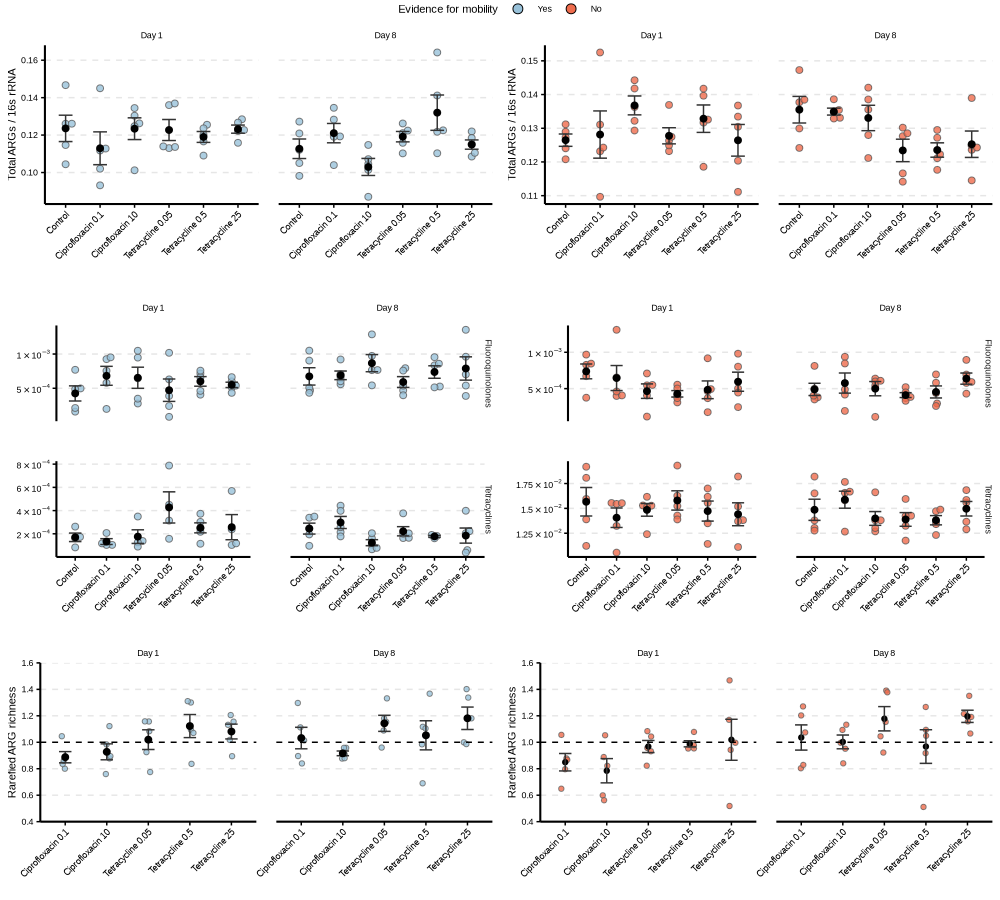

In [72]:
%%R  -i df_ARG_normalized_tot -i df_rare_ratio -w 1000 -h 900 -r 100 

df_ARG_normalized_tot$Treatment <- factor(df_ARG_normalized_tot$Treatment, 
                                       levels = c("Input", "Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                       "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))

df_ARG_normalized_tot <- filter(df_ARG_normalized_tot, Treatment != "Input")
  
  # Calculate mean and standard deviation
  summary_data <- df_ARG_normalized_tot[df_ARG_normalized_tot$Mobile == "Yes", ] %>%
    group_by(Treatment, Day) %>%
    summarise(
      mean_count = mean(Count_normalized),
      sd_count = sd(Count_normalized)/sqrt(n()),
      .groups = "drop"
    )
  color_swarm_yes <- "#98c1d9"
  color_stats <- "#333333"
  color_swarm_no <- "#ee6c4d"
  
  # Base plot
  plot_ARG_ab_tot_yes <- ggplot(df_ARG_normalized_tot[df_ARG_normalized_tot$Mobile == "Yes", ], aes(x = Treatment, y = Count_normalized)) +
 geom_beeswarm(fill = color_swarm_yes, color = "#5B5A5A", size = 2, cex = 3, alpha = 0.8, shape = 21) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = color_stats, 
                  width = 0.4,
                  size = 0.5) +
  geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "black",
               size = 2) +
    facet_grid(~Day, scales="free_x", space ="free") +
    scale_y_continuous(n.breaks = 5) +
    theme(
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "none",
      plot.title = element_blank()
    ) +
    ylab("Total ARGs / 16s rRNA") +
    xlab("")+ 
    theme(text = element_text(size = 8)) 
    
# Calculate mean and standard deviation
  summary_data <- df_ARG_normalized_tot[df_ARG_normalized_tot$Mobile == "No", ] %>%
    group_by(Treatment, Day) %>%
    summarise(
      mean_count = mean(Count_normalized),
      sd_count = sd(Count_normalized)/sqrt(n()),
      .groups = "drop"
    )
 
  # Base plot
  plot_ARG_ab_tot_no <- ggplot(df_ARG_normalized_tot[df_ARG_normalized_tot$Mobile == "No", ], aes(x = Treatment, y = Count_normalized)) +
    geom_beeswarm(fill = color_swarm_no, color = "#5B5A5A", size = 2, cex = 3, alpha = 0.8, shape = 21) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = color_stats, 
                  width = 0.4,
                  size = 0.5) +
  geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "black",
               size = 2) +
    facet_grid(~Day, scales="free_x", space ="free") +
    scale_y_continuous(n.breaks = 5) +
    theme(
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "none",
      plot.title = element_blank()
    ) +
    ylab("Total ARGs / 16s rRNA") +
    xlab("")+ 
    theme(text = element_text(size = 8)) 

df_filtered <- df_phenotype_normalized %>%
  filter(Drug_Class %in% c("Tetracyclines", "Fluoroquinolones"))

df_filtered$Treatment<- factor(df_filtered$Treatment, 
                                        levels = c("Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                        "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))
df_filtered <- filter(df_filtered, Day != "Day 0")
# Calculate mean and standard deviation
  summary_data <- df_filtered[df_filtered$Mobile == "Yes", ] %>%
    group_by(Treatment, Day, Drug_Class) %>%
    summarise(
      mean_count = mean(Count_normalized),
      sd_count = sd(Count_normalized)/sqrt(n()),
      .groups = "drop"
    )
  
  # Base plot
  plot_ARG_ab_class_Yes <- ggplot(df_filtered[df_filtered$Mobile == "Yes", ], aes(x = Treatment, y = Count_normalized)) +
    geom_beeswarm(fill = color_swarm_yes, color = "#5B5A5A", size = 2, cex = 3, alpha = 0.8, shape = 21) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = color_stats, 
                  width = 0.4,
                  size = 0.5) +
  geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "black",
               size = 2) +
    facet_grid(Drug_Class ~ Day, scales="free", space ="free_x") +
    scale_y_continuous(n.breaks = 5,
                        labels = function(x) {
                        parse(text = gsub("e", " %*% 10^", scales::scientific(x)))
    }) +
    theme(
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "none",
      plot.title = element_blank()
    ) +
    ylab("") +
    xlab("")+ 
    theme(text = element_text(size = 8)) 
    
# Calculate mean and standard deviation
  summary_data <- df_filtered[df_filtered$Mobile == "No", ] %>%
    group_by(Treatment, Day, Drug_Class) %>%
    summarise(
      mean_count = mean(Count_normalized),
      sd_count = sd(Count_normalized)/sqrt(n()),
      .groups = "drop"
    )

  # Base plot
  plot_ARG_ab_class_No <- ggplot(df_filtered[df_filtered$Mobile == "No", ], aes(x = Treatment, y = Count_normalized)) +
    geom_beeswarm(fill = color_swarm_no, color = "#5B5A5A", size = 2, cex = 3, alpha = 0.8, shape = 21) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = color_stats, 
                  width = 0.4,
                  size = 0.5) +
  geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "black",
               size = 2) +
    facet_grid(Drug_Class ~ Day, scales="free", space ="free_x") +
    scale_y_continuous(n.breaks = 5,
                        labels = function(x) {
                        parse(text = gsub("e", " %*% 10^", scales::scientific(x)))
    }) +
    theme(
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "none",
      plot.title = element_blank()
    ) +
    ylab("") +
    xlab("")+ 
    theme(text = element_text(size = 8)) 

df_rare_ratio$Treatment<- factor(df_rare_ratio$Treatment, 
                                        levels = c("Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                        "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))

# Calculate mean and standard deviation
  summary_data <- df_rare_ratio[df_rare_ratio$Mobile == "Yes", ] %>%
    group_by(Treatment, Day) %>%
    summarise(
      mean_count = mean(Ratio),
      sd_count = sd(Ratio)/sqrt(n()),
      .groups = "drop"
    )

  # Base plot
  plot_ARG_rare_yes <- ggplot(summary_data, aes(x = Treatment, y = mean_count)) +
 # geom_bar(stat = "identity", width = 0.4, fill = "#f0f0f0", color = "black") +
        geom_jitter(data= df_rare_ratio[df_rare_ratio$Mobile == "Yes", ],
                  aes(x = Treatment, y = Ratio), 
                  color = "#666564", 
                  fill = color_swarm_yes,
                  shape=21,
                  size = 1.5,
                  width = .1,
                  alpha = 0.8) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = color_stats, 
                  width = 0.3,
                  size = 0.5) +
      geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "black",
               size = 2) +
    facet_grid( ~ Day, scales="free", space ="free_x") +
    # scale_y_continuous(expand = c(0, 0), limits = c(0, 5),) +
      scale_y_continuous(expand = c(0, 0), 
                     limits = c(0.4, 1.6)) + 
 #   scale_y_discrete(n.breaks = 5) +
    theme(
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "none",
      plot.title = element_blank()
    ) +
    ylab("Rarefied ARG richness") +
    xlab("")+ 
    theme(text = element_text(size = 8)) +
    geom_hline(yintercept = 1, linetype = "dashed")

# Calculate mean and standard deviation
  summary_data <- df_rare_ratio[df_rare_ratio$Mobile == "No", ] %>%
    group_by(Treatment, Day) %>%
    summarise(
      mean_count = mean(Ratio),
      sd_count = sd(Ratio)/sqrt(n()),,
      .groups = "drop"
    )

  # Base plot
  plot_ARG_rare_No <- ggplot(summary_data, aes(x = Treatment, y = mean_count)) +
  #  geom_bar(stat = "identity", width = 0.4, fill = "#f0f0f0", color = "black") +
        geom_jitter(data= df_rare_ratio[df_rare_ratio$Mobile == "No", ],
                  aes(x = Treatment, y = Ratio), 
                  color = "#666564", 
                  fill = color_swarm_no,
                  shape=21,
                  size = 1.5,
                  width = .1,
                  alpha = 0.8) +
            geom_point(data = summary_data,
               aes(y = mean_count),
               colour = "black",
               size = 1.5) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = color_stats, 
                  width = 0.3,
                  size = 0.5) +
   
    facet_grid( ~ Day, scales="free", space ="free_x") +
      scale_y_continuous(expand = c(0, 0), 
                     limits = c(0.4, 1.6)) + 
                    # breaks = c(0.5, 1, 1.5),
                    # labels = c("0.5", "1", "1.5")) +
 #   scale_y_discrete(n.breaks = 5) +
    theme(
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "none",
      plot.title = element_blank()
    ) +
    ylab("Rarefied ARG richness") +
    xlab("") + 
    theme(text = element_text(size = 8)) +
    geom_hline(yintercept = 1, linetype = "dashed")
        
legend_plot <- ggplot() +
  geom_point(data = data.frame(x = c(1,2), y = rep(1, 2), 
                              Mobile = factor(c("Yes", "No"), levels = c("Yes", "No"))),
             aes(x = x, y = y, fill = Mobile), 
             shape = 21, size = 3) +
  scale_fill_manual("Evidence for mobility",
                    values = c("Yes" = "#98c1d9", "No" = "#ee6c4d")) +
  theme_void() +
  theme(legend.position = "top",
        legend.direction = "horizontal",
        legend.spacing.x = unit(0.5, "cm"),
        text = element_text(size = 8))

# Extract the legend
legend <- get_legend(legend_plot)

plot_ARG_ab_class_Yes <- plot_ARG_ab_class_Yes +
  theme(
    strip.text = element_text(margin = margin(b = 10, t = 10)),
    panel.spacing = unit(2, "lines")
  )

plot_ARG_ab_class_No <- plot_ARG_ab_class_No +
  theme(
    strip.text = element_text(margin = margin(b = 10, t = 10)),
    panel.spacing = unit(2, "lines")
  )
  
# Combine plots with the legend
panel_1_ARG_abundance_richness <- ggarrange(
  as_ggplot(legend),
  ggarrange(plot_ARG_ab_tot_yes, plot_ARG_ab_tot_no,
            plot_ARG_ab_class_Yes, plot_ARG_ab_class_No,
            plot_ARG_rare_yes, plot_ARG_rare_No,
            ncol = 2,
            heights = c(1.5, 2, 1.5),
            nrow = 3),
  nrow = 2,
  heights = c(0.1, 5)
)
plot(panel_1_ARG_abundance_richness)

**Figure 1**: The effects of antibiotic exposure on the abundance and richness of antibiotic resistance genes (ARGs). The blue colors (left column) correspond to ARGs with evidence for mobility, while the red color (right column) corresponds to ARGs with no evidence for mobility, as assessed from a screening of plasmids and genomic islands. Plots A-B) show cumulative ARG abundance across all drug classes. Figures C-D) illustrates the cumulative abundance of drug classes relevant for this study, namely tetracycline and fluoroquinolones. Finally, E-F) shows the ratio of rarefied ARG richness between each treatment and the control for each day. A paired two-tailed Student's t-test was performed to assess the significance of any changes resulting from the exposure, and the p-values were corrected for multiple testing using the FDR approach. Error bars correspond to standard error of the mean, and the black dot indicates the mean value. 

In [73]:
def get_Gene(sample):
    if '|ARO:' in sample:
        return sample.split("|")[3].split("_[")[0]
    else:
        return sample.split("|")[-1]
    
def get_significance_stars(fdr):
    if fdr < 0.001:
        return '***'
    elif fdr < 0.01:
        return '**'
    elif fdr < 0.05:
        return '*'
    else:
        return 'ns'

dict_ARG_diff = {
    "Gene_name":[],
    "Treatment":[],
    "Day":[],
    "Mobile":[],
    "Drug Class":[],
    "Diff":[],
    "FDR":[]
}

min_nonzero = df_ARG_normalized[df_ARG_normalized['Count_normalized'] > 0].Count_normalized.min()
pseudocount = min_nonzero

for index, row in signif_ARGS.iterrows():
    name = row["Gene_name"]
    treatment = row["Treatment"]
    day = row["Day"]
    mobile = row["Mobile"]
    drug_class = row["Drug Class"]
    FDR = row["FDR"]
    logFC = row["logFC"]
    
    df_tmp = df_ARG_normalized[(df_ARG_normalized.Day == day) & (df_ARG_normalized.Treatment.isin(["Control", treatment])) & (df_ARG_normalized.Reference.apply(get_Gene) == name)]
    
    # Determine which samples to check based on logFC
    check_treatment = treatment if logFC > 0 else "Control"
    df_tmp_coverage  = coverage_df_arg[(coverage_df_arg.Day == day) & (coverage_df_arg.Treatment_clean == check_treatment) & (coverage_df_arg.Gene.apply(get_Gene) == name)]
    
    df_tmp_coverage_median = df_tmp_coverage.groupby("Replicate").coverage.median()
    list_median_coverage = df_tmp_coverage_median.values.tolist()
    
    # Calculate number of samples with abundance above 5 and filter
    
    median_coverage_pass = [i for i in list_median_coverage if i >= 1]
    median_coverage_pass_len = len(median_coverage_pass)
    
    if median_coverage_pass_len >= 3:
        for rep in df_tmp.Replicate.unique():
            val_treatment = df_tmp[(df_tmp.Replicate == rep) & (df_tmp.Treatment == treatment)].Count_normalized
            val_control = df_tmp[(df_tmp.Replicate == rep) & (df_tmp.Treatment == "Control")].Count_normalized
            
               
            # Handle empty or zero values for treatment
            if val_treatment.empty or val_treatment.values[0] == 0:
                val_treatment_value = pseudocount
            else:
                val_treatment_value = val_treatment.values[0] + pseudocount
                
            # Handle empty or zero values for control
            if val_control.empty or val_control.values[0] == 0:
                val_control_value = pseudocount
            else:
                val_control_value = val_control.values[0] + pseudocount
            
            Diff = val_treatment_value / val_control_value
            
            dict_ARG_diff["Day"].append(day)
            dict_ARG_diff["Treatment"].append(treatment)
            dict_ARG_diff["Gene_name"].append(name)
            dict_ARG_diff["Mobile"].append(mobile)
            dict_ARG_diff["Drug Class"].append(drug_class)
            dict_ARG_diff["Diff"].append(Diff)
            dict_ARG_diff["FDR"].append(FDR)
        
df_arg_diff = pd.DataFrame.from_dict(dict_ARG_diff)    
df_arg_diff["Gene_name_"] = df_arg_diff["Gene_name"].str.replace("_", " ")
# Replace card short names with gene name
name_mapping = {
    'vanR in vanO cl': 'vanR',
    'adeF': 'adeF',
    'Paer CpxR': 'cpxR',
    'vanO': 'vanO',
    'vanH in vanO cl': 'vanH'
}

# Replace the values using map or replace function
df_arg_diff['Gene_name_'] = df_arg_diff['Gene_name_'].map(name_mapping)

df_arg_diff['Significance'] = df_arg_diff['FDR'].apply(get_significance_stars)

In [74]:
signif_ARGS[["Gene_name", "logFC", "FDR", "Treatment", "Day", "Mobile", "Drug Class"]]

,Gene_name,logFC,FDR,Treatment,Day,Mobile,Drug Class
0,Paer_CpxR,1.788074,0.001045,Tetracycline 0.5,Day 8,Yes,Multiple
1,vanO,3.749569,0.002062,Tetracycline 25,Day 8,Yes,Glycopeptides/Cycloserine
2,vanH_in_vanO_cl,3.042932,0.016959,Tetracycline 25,Day 8,Yes,Glycopeptides/Cycloserine


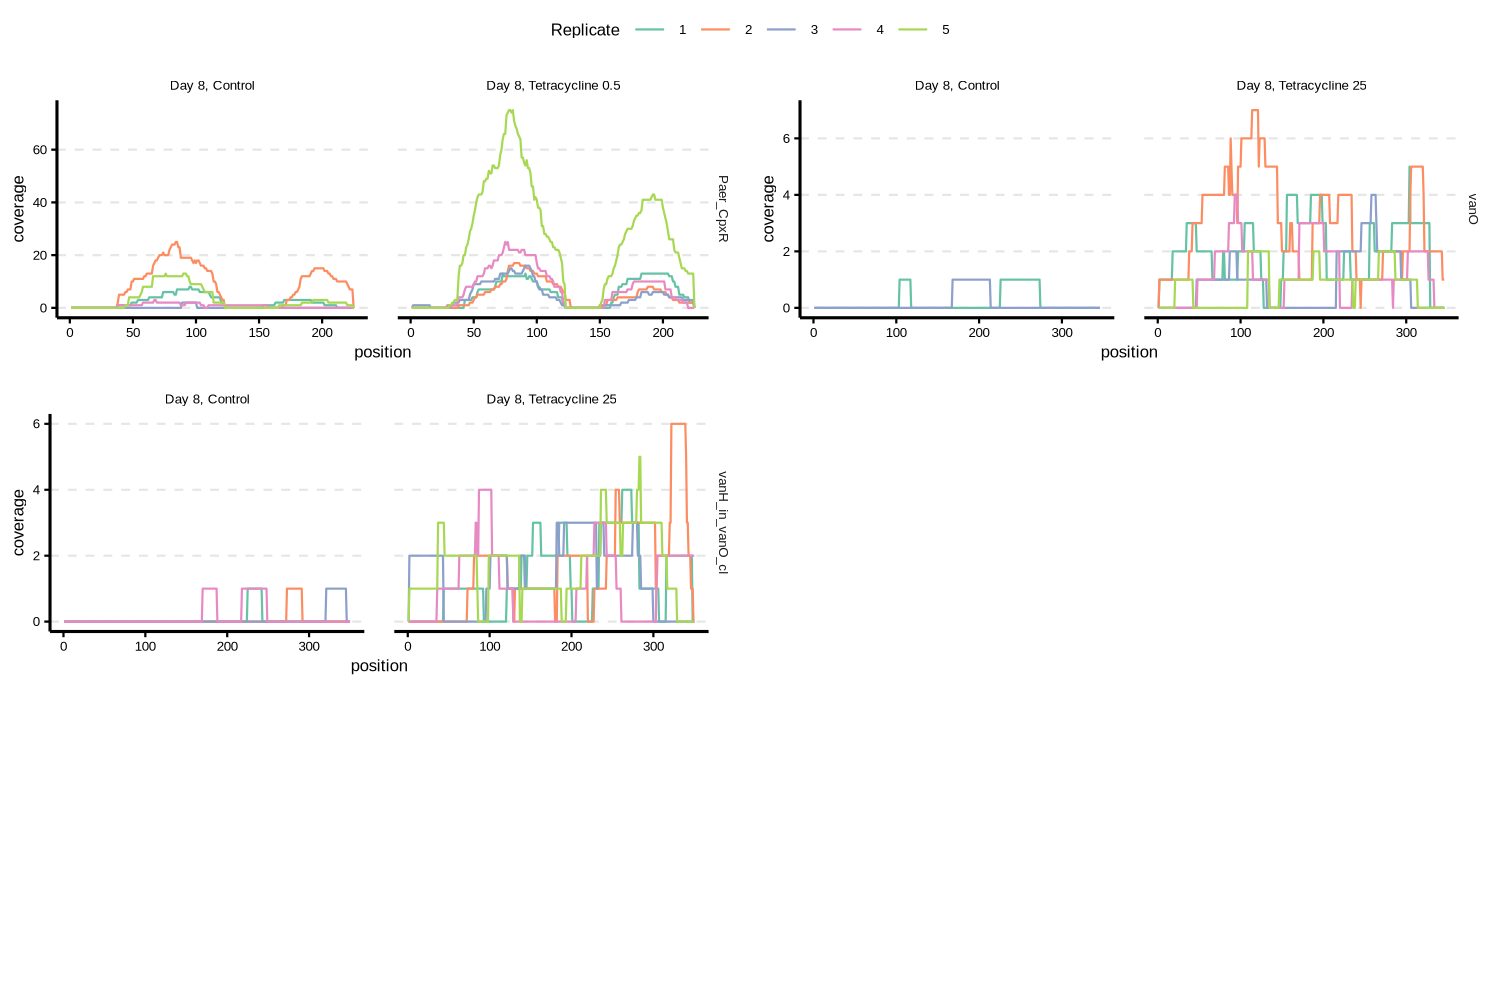

In [75]:
%%R -i coverage_df_arg -w 1500 -h 1000 -r 150 -i signif_ARGS -o coverage_df_arg_sig

# First create the combined column with comma format
coverage_df_arg_sig <- coverage_df_arg %>%
  mutate(Day_Treatment = paste(Day, Treatment_clean, sep = ", ")) %>%
  mutate(Day_Treatment = factor(Day_Treatment, 
                               # Put all Control treatments first in the levels
                               levels = c("Day 1, Control", "Day 1, Ciprofloxacin 10",
                                        "Day 8, Control", "Day 8, Tetracycline 0.05",
                                        "Day 8, Tetracycline 0.5",
                                        "Day 8, Tetracycline 25")))
# Define the combinations we want to plot with comma format
plot_combinations <- list(

  list(day_treatment = c("Day 8, Control", "Day 8, Tetracycline 0.5"),
       genes = "Paer_CpxR"),
  

  list(day_treatment = c("Day 8, Control", "Day 8, Tetracycline 25"),
       genes = "vanO"),
  
  list(day_treatment = c("Day 8, Control", "Day 8, Tetracycline 25"),
       genes = "vanH_in_vanO_cl")
)

# Modified plotting function to use the combined column
create_coverage_plot <- function(data, day_treatment, genes) {
  plot <- data %>%
    filter(Day_Treatment %in% day_treatment,
           Gene_name %in% genes) %>%
    ggplot(aes(x = position, y = coverage, color = Replicate)) +
    geom_path() +
    scale_color_manual(values = c('#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854')) +
    facet_grid(Gene_name ~ Day_Treatment) +
    theme(
      strip.clip = "off",
      legend.key = element_blank(),
      strip.text.x = element_text(colour = "black"),
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
      axis.text.x = element_text(color = "black"),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      legend.position = "right",
      plot.title = element_blank()
    ) +
    theme(text = element_text(size = 8)) 
  
  return(plot)
}

# Create the plots
plots <- list()
for(combo in plot_combinations) {
  plots[[length(plots) + 1]] <- create_coverage_plot(
    coverage_df_arg_sig,
    day_treatment = combo$day_treatment,
    genes = combo$genes
  )
}

# Combine plots using ggarrange
ARG_ccov_gene <- ggarrange(
  plotlist = plots,
  ncol = 2,
  nrow=3,
  common.legend = TRUE
)

ARG_ccov_gene

 **Figure**: This plot shows the coverage across all significant ARGs in the control in relation to the treated sample. The colors represent the coverage in different replicates per treatment.

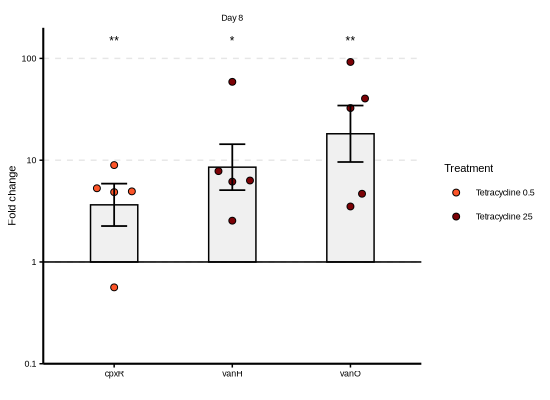

In [76]:
%%R -i df_arg_diff -w 550 -h 400 -r 100

df_arg_diff$Significance <- factor(df_arg_diff$Significance, 
                                   levels = c("*", "**", "***"))

# Calculate statistics for plot
summary_data <- df_arg_diff %>%
  group_by(Day, Gene_name_, Treatment) %>%
  summarise(
    # Calculate mean in log10 space then transform back
    mean_count = 10^(mean(log10(Diff), na.rm = TRUE)),
    # Calculate standard error in log10 space
    se_log = sd(log10(Diff))/sqrt(n()),
    # Calculate error bar limits by transforming back from log space
    ymin = 10^(mean(log10(Diff)) - se_log),
    ymax = 10^(mean(log10(Diff)) + se_log),
    .groups = "drop"
  ) 

# Get unique significance values for each combination
sig_data <- df_arg_diff %>%
  select(Day, Gene_name_, Treatment, Significance) %>%
  distinct()

max_y <- 15  
sig_y <- max_y * 0.95  

plot_individual_ARGs <- ggplot() +
  geom_bar(data = summary_data, 
           aes(x = Gene_name_, y = mean_count),
           stat = "identity", 
           width = 0.4, 
           fill = "#f0f0f0", 
           color = "black", 
           show.legend = FALSE) +
  # Beeswarm with fill aesthetic and its own guide name
  geom_beeswarm(data = df_arg_diff,
                aes(x = Gene_name_, y = Diff, fill = Treatment),
                size = 2, 
                cex = 5, 
                shape = 21,
                show.legend = TRUE) +
    scale_fill_manual(values=c('#FC5428','#7c0206')) +
    new_scale_fill() +
    new_scale_color() +
  # Significance dots with color aesthetic and its own guide name
  geom_text(data = sig_data,
             aes(x = Gene_name_, y = 150, label = Significance),
             size = 3) +
  # Two separate scales with different guide names
  geom_errorbar(data = summary_data,
                aes(x = Gene_name_,
                    y = mean_count, 
                    ymin = ymin, 
                    ymax = ymax),
                colour = "black", 
                width = 0.22,
                size = 0.6,
                show.legend = FALSE) +
  facet_grid(~Day, scales = "free", space = "free_x") + 
  scale_y_continuous(expand = c(0, 0), 
                     limits = c(0.1, 200), 
                     breaks = c(0.1, 1, 10, 100),
                     labels = c("0.1", "1", "10", "100"),
                     trans = 'log10') +
  theme(
    legend.key = element_blank(),
    strip.text.x = element_text(colour = "black"),
    panel.spacing = unit(1, "lines"),
    strip.background = element_rect(colour = NA, fill = NA),
    axis.line = element_line(size = 0.7, colour = "black"),
    panel.background = element_rect(fill = NA),
    axis.text.y = element_text(color = "black"),
    axis.text.x = element_text(color = "black"),#, angle = 45, hjust = 1),
    axis.ticks = element_line(color = 'black'),
    panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
    panel.grid.major.x = element_blank(),
    plot.title = element_blank()
  ) +
  theme(text = element_text(size = 8)) + 
  ylab("Fold change") +
  xlab("") +
  geom_hline(yintercept = 1) 

print(plot_individual_ARGs)

**Figure 2**: Individual antibiotic resistance genes selected for by the antibiotic exposure. The fold change represents the ratio of the gene abundance in treated samples compared to controls. Colors correspond to different antibiotic exposures. Statistical testing was performed using edgeR, after which p-values were corrected for multiple testing using the FDR approach. The stars denote statistical significance: * p <0.05, ** p<0.01. Error bars represent standard error of the mean. 

## Taxonomy



In [77]:
%%R -i df_genera -o genera_permanova

# Create empty dataframe to store results
genera_permanova <- data.frame(
  Day = character(),
  Treatment = character(),
  P_value = numeric(),
  stringsAsFactors = FALSE
)

# Get unique days and treatments
unique_days <- unique(df_genera$Day[!df_genera$Day %in% c("Day 0")])
unique_treatments <- unique(df_genera$Treatment[!df_genera$Treatment %in% c("Control", "Input")])

# Loop through each day and treatment
for (day in unique_days) {
  for (treatment in unique_treatments) {
    # Filter data for current day and only current treatment + control
    df_tmp <- df_genera %>%
      filter(Day == day, 
             Treatment %in% c(treatment, "Control")) %>%
      pivot_wider(
        names_from = Taxa,
        values_from = nr_16s,
        id_cols = Sample
      ) %>%
      mutate(across(where(is.numeric), ~replace_na(., 0)))
    
    # Create split dataframe
    split_df <- df_tmp %>%
      select(Sample) %>%
      separate(Sample, 
               into = c("Sample", "Replicate"), 
               sep = "_(?=[^_]+$)")
    
    # Keep original df without Sample column
    original_df <- df_tmp %>%
      select(-Sample)
    
    # Perform PERMANOVA
    perm_result <- (with(split_df, 
                        adonis2(original_df ~ Sample, 
                               data = split_df, 
                               permutations = 999)))
    
    # Extract p-value and append to results
    genera_permanova <- rbind(genera_permanova, 
                       data.frame(
                         Day = day,
                         Treatment = treatment,
                         P_value = perm_result$`Pr(>F)`[1]
                       ))
  }
}
genera_permanova$FDR <- p.adjust(genera_permanova$P_value, method = "BH")

This code calculates the fold change for each significant genera. It also identifies if the genera increased or decreased in abundance in the treated sample and makes sure that it has an abundance above 5 in at least 3/5 replicates. 5 meaning that at least 5 reads mapped to it. 

In [78]:
dict_genus_diff = {
    "Genera": [], "Treatment": [], "Day": [], "Diff": [],
    "FDR": [], "Control_value": [], "Treated_value": []
}

for index, row in edgeR_results_genus_sig.iterrows():
    name = row["Taxa"]
    treatment = row["Treatment"]
    day = row["Day"]
    FDR = row["FDR"]
    logFC = row["logFC"]
    
    # df with those samples
    df_tmp = df_genera[(df_genera.Day == day) & 
                       (df_genera.Treatment.isin(["Control", treatment])) & 
                       (df_genera.Taxa == name)]
    
    # Determine which samples to check based on logFC
    check_treatment = treatment if logFC > 0 else "Control"
    
    # Calculate number of samples with abundance above 5 and filter
    values = df_tmp[df_tmp.Treatment == check_treatment].nr_16s.values.tolist()
    nr_replicates_above_five = [i for i in values if i >= 5]
    
    if len(nr_replicates_above_five) < 3:
        continue
        
    # For each replicate extract 16s abundance
    for rep in df_tmp.Replicate.unique():
        val_treatment = df_tmp[(df_tmp.Replicate == rep) & 
                             (df_tmp.Treatment == treatment)].nr_16s
        val_control = df_tmp[(df_tmp.Replicate == rep) & 
                           (df_tmp.Treatment == "Control")].nr_16s
        
        min_nonzero = df_tmp[df_tmp['nr_16s'] > 0].nr_16s.min()
        pseudocount = min_nonzero
        
        # Handle empty or zero values for treatment
        if val_treatment.empty or val_treatment.values[0] == 0:
            val_treatment_value = pseudocount
        else:
            val_treatment_value = val_treatment.values[0] + pseudocount
            
        # Handle empty or zero values for control
        if val_control.empty or val_control.values[0] == 0:
            val_control_value = pseudocount
        else:
            val_control_value = val_control.values[0] + pseudocount
        
        # Calculate fold change
        Diff = val_treatment_value / val_control_value
        
        # Append all values at once
        dict_genus_diff["Day"].append(day)
        dict_genus_diff["Treatment"].append(treatment)
        dict_genus_diff["Genera"].append(name)
        dict_genus_diff["Diff"].append(Diff)
        dict_genus_diff["FDR"].append(FDR)
        dict_genus_diff["Control_value"].append(val_control.values[0])
        dict_genus_diff["Treated_value"].append(val_treatment.values[0])

# Convert to df and add metadata
df_genera_diff = pd.DataFrame.from_dict(dict_genus_diff)
df_genera_diff['Significance'] = df_genera_diff['FDR'].apply(get_significance_stars)
df_genera_diff = df_genera_diff[~df_genera_diff.Genera.str.contains("Unclassified")]
df_genera_diff["Genera"] = df_genera_diff.Genera.str.split(";").str[-1]

`summarise()` has grouped output by 'Day'. You can override using the `.groups`
argument.


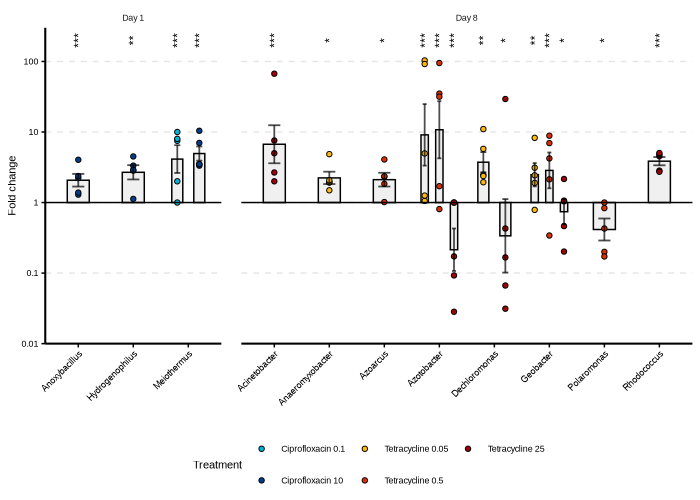

In [79]:
%%R -i df_genera_diff -w 700 -h 500 -r 100

df_genera_diff$Significance <- factor(df_genera_diff$Significance, 
                                   levels = c("*", "**", "***"))

# Calculate statistics for plot
summary_data <- df_genera_diff %>%
  group_by(Day, Genera, Treatment) %>%
  summarise(
    # Calculate mean in log10 space then transform back
    mean_count = 10^(mean(log10(Diff), na.rm = TRUE)),
    # Calculate standard error in log10 space
    se_log = sd(log10(Diff))/sqrt(n()),
    # Calculate error bar limits by transforming back from log space
    ymin = 10^(mean(log10(Diff)) - se_log),
    ymax = 10^(mean(log10(Diff)) + se_log),
    .groups = "drop"
  ) 
# Get unique significance values for each combination
sig_data <- df_genera_diff %>%
  select(Day, Genera, Treatment, Significance) %>%
  distinct()

max_values <- df_genera_diff %>%
  group_by(Day, Genera) %>%
  summarise(max_val = max(Diff, na.rm = TRUE)) %>%
  mutate(sig_position = max_val * 1.2)  

  plot_individual_genera <- ggplot() +
    geom_bar(data = summary_data, 
             aes(x = Genera, y = mean_count, group = Treatment),
             position = position_dodge(width = 0.8),
             stat = "identity", 
             width = 0.4, 
             fill = "#f0f0f0", 
             color = "black", 
             show.legend = FALSE) +
    geom_point(data = df_genera_diff,
                  aes(x = Genera, y = Diff, fill = Treatment, group = Treatment),
                  position = position_dodge(width = 0.8),
                  size = 1.5, 
                  shape = 21,
                  show.legend = TRUE) +
      scale_fill_manual(values=c('#00b4d8','#023e8a','#ffba08','#dc2f02','#9d0208')) +
      geom_text(data = sig_data,
               aes(x = Genera, y = 200, label = Significance, group = Treatment),
               size = 3, position = position_dodge(width = 0.8),
               angle = 90) +
    # Two separate scales with different guide names
    geom_errorbar(data = summary_data,
                  aes(x = Genera,
                      y = mean_count, 
                      ymin = ymin, 
                      ymax = ymax,
                      group = Treatment),
                  position = position_dodge(width = 0.8),
                  colour = "black", 
                  width = 0.22,
                  size = 0.6,
                  alpha = 0.7,
                  show.legend = FALSE) +
    scale_y_continuous(expand = c(0, 0), 
                       limits = c(0.01, 300), 
                       breaks = c(0.01, 0.1, 1, 10, 100),
                       labels = c("0.01", "0.1", "1", "10", "100"),
                       trans = 'log10') +
    geom_hline(yintercept = 1) +
    facet_grid(~Day, space ="free", scales = "free") +
  theme(
     # strip.text = element_blank(), 
      panel.spacing = unit(1, "lines"),
      strip.background = element_rect(colour = NA, fill = NA),
      axis.line = element_line(size = 0.7, colour = "black"),
      panel.background = element_rect(fill = NA),
      axis.text.y = element_text(color = "black"),
    axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
      axis.ticks = element_line(color = 'black'),
      panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
      panel.grid.major.x = element_blank(),
      plot.title = element_blank(),
      legend.spacing = unit(0, "cm"),  
      legend.margin = margin(0, 0, 0, 0),  
      legend.box.margin = margin(0, 0, 0, 0),
      legend.position="bottom"
  ) +
    theme(text = element_text(size = 8)) + 
    ylab("Fold change") +
    guides(fill = guide_legend(nrow = 2)) +
    xlab("") 

print(plot_individual_genera)

**Figure**: Effects on fold change of significant genera. Colors correspond to antibiotic exposure and concentrations (in µg/g). Error bars correspond to standard error of the mean. The statistical analysis was performed using the edgeR package, and the p-values were corrected for multiple testing using the FDR approach. The asterisks correspond to statistical significance: * p <0.05, ** p<0.01, *** p<0.001.

In [80]:
dict_rare_genus = {
    "Sample": [],
    "Day": [],
    "Treatment": [],
    "Replicate": [],
    "Ratio": []
}

for Treatment in df_rare_genera[~df_rare_genera.Treatment.isin(["Control", "Input"])].Treatment.unique():
    for Day in df_rare_genera[df_rare_genera.Day != "Day 0"].Day.unique():
        for Replicate in df_rare_genera[df_rare_genera.Replicate != "6"].Replicate.unique():
                df_tmp = df_rare_genera[(df_rare_genera.Treatment.isin([Treatment, "Control"])) &
                                  (df_rare_genera.Day == Day) &
                                  (df_rare_genera.Replicate == Replicate)
                                  ]
                val_control = df_tmp[df_tmp.Treatment == "Control"].Rarefied_values[0]
                val_treatment = df_tmp[df_tmp.Treatment == Treatment].Rarefied_values[0]
                val_ratio = val_treatment / val_control
                
                # Get the sample name from the treatment row
                sample_name = df_tmp[df_tmp.Treatment == Treatment].Sample.iloc[0]
                
                # Append all values to the dictionary
                dict_rare_genus["Sample"].append(sample_name)
                dict_rare_genus["Day"].append(Day)
                dict_rare_genus["Treatment"].append(Treatment)
                dict_rare_genus["Replicate"].append(Replicate)
                dict_rare_genus["Ratio"].append(val_ratio)

# Convert to DataFrame if needed
df_rare_genus = pd.DataFrame(dict_rare_genus)

/tmp/ipykernel_60262/3287249269.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_control = df_tmp[df_tmp.Treatment == "Control"].Rarefied_values[0]
/tmp/ipykernel_60262/3287249269.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_treatment = df_tmp[df_tmp.Treatment == Treatment].Rarefied_values[0]


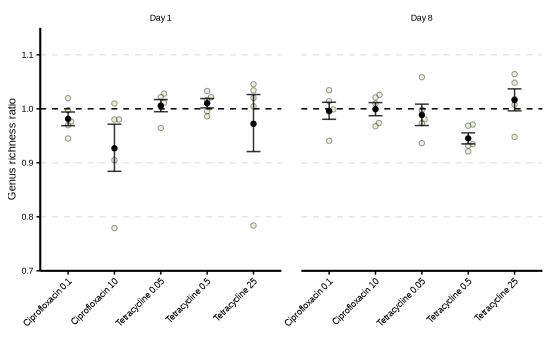

In [81]:
%%R -i df_rare_genus -w 550 -h 350 -r 100
df_rare_genus$Treatment<- factor(df_rare_genus$Treatment, 
                                        levels = c("Input", "Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                        "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))
summary_data <- df_rare_genus %>%
  group_by(Day, Treatment) %>%
  summarise(
    # Calculate mean in log10 space then transform back
    mean_count = 10^(mean(log10(Ratio), na.rm = TRUE)),
    # Calculate standard error in log10 space
    se_log = sd(log10(Ratio))/sqrt(n()),
    # Calculate error bar limits by transforming back from log space
    ymin = 10^(mean(log10(Ratio)) - se_log),
    ymax = 10^(mean(log10(Ratio)) + se_log),
    .groups = "drop"
  ) 
  
# Get unique significance values for each combination
sig_data <- df_rare_genus %>%
  select(Day, Treatment) %>%
  distinct()

plot_genera_richness <- ggplot() +
  geom_beeswarm(data = df_rare_genus,
                aes(x = Treatment, y = Ratio),
                size = 1.5, 
                cex = 2, 
                shape = 21,
                fill = "#C1D998",
                alpha = 0.4,
                show.legend = TRUE) +  
  geom_errorbar(data = summary_data,
                aes(x = Treatment,
                    y = mean_count, 
                    ymin = ymin, 
                    ymax = ymax),
                  colour = "black", 
              width = 0.3,
                  size = 0.5,
                  alpha = 0.8,
                show.legend = FALSE) +
      geom_point(data = summary_data,
               aes(y = mean_count, x = Treatment),
               colour = "black",
               size = 1.5) +
  facet_grid(~Day, scales = "free", space = "free_x") + 
  scale_y_continuous(expand = c(0, 0), 
                     limits = c(0.7, 1.15)) +
  theme(
    legend.key = element_blank(),
    strip.text.x = element_text(colour = "black"),
    panel.spacing = unit(1, "lines"),
    strip.background = element_rect(colour = NA, fill = NA),
    axis.line = element_line(size = 0.7, colour = "black"),
    panel.background = element_rect(fill = NA),
    axis.text.y = element_text(color = "black"),
    axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
    axis.ticks = element_line(color = 'black'),
    panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
    panel.grid.major.x = element_blank(),
    plot.title = element_blank()
  ) +
  theme(text = element_text(size = 8)) + 
  ylab("Genus richness ratio") +
  xlab("") +
  geom_hline(yintercept = 1, linetype = "dashed") 

print(plot_genera_richness)

**Figure**: Effects on rarefied genus richness.

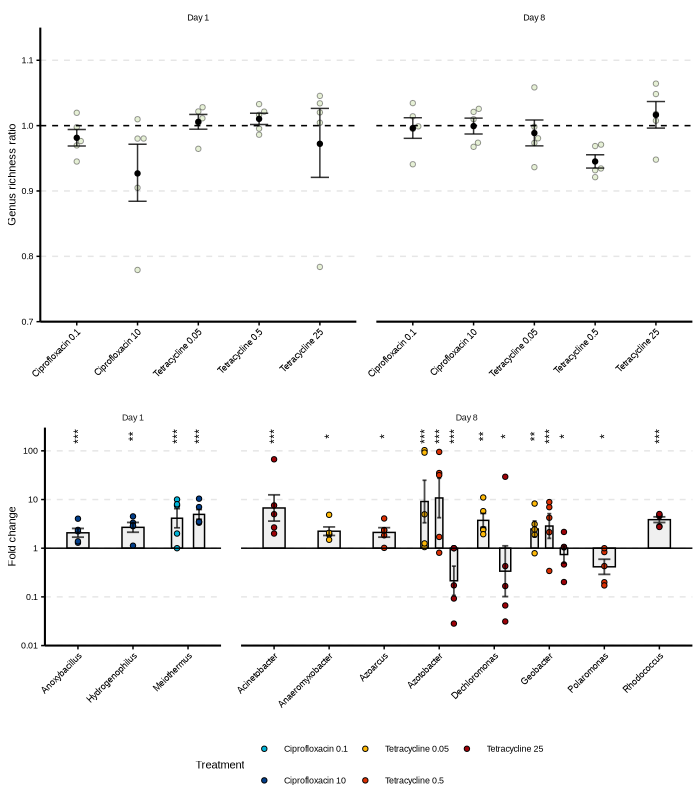

In [82]:
%%R -i df_MGE_class -w 700 -h 800 -r 100


ggarrange(plot_genera_richness, plot_individual_genera, ncol=1)

**Figure 4: Effects of antibiotic exposure on taxonomic composition.** Effects on rarefied genus richness A) and fold change of significant genera B). The fold change was calculated by dividing the abundance of each genus in the treatment by the control, in a paired fashion for each replicate. Colors correspond to antibiotic exposure and concentrations (in µg/g). Error bars correspond to standard error of the mean. The statistical analysis was performed using the edgeR package, and the p-values were corrected for multiple testing using the FDR approach. The asterisks correspond to statistical significance: * p <0.05, ** p<0.01, *** p<0.001.

## MGE

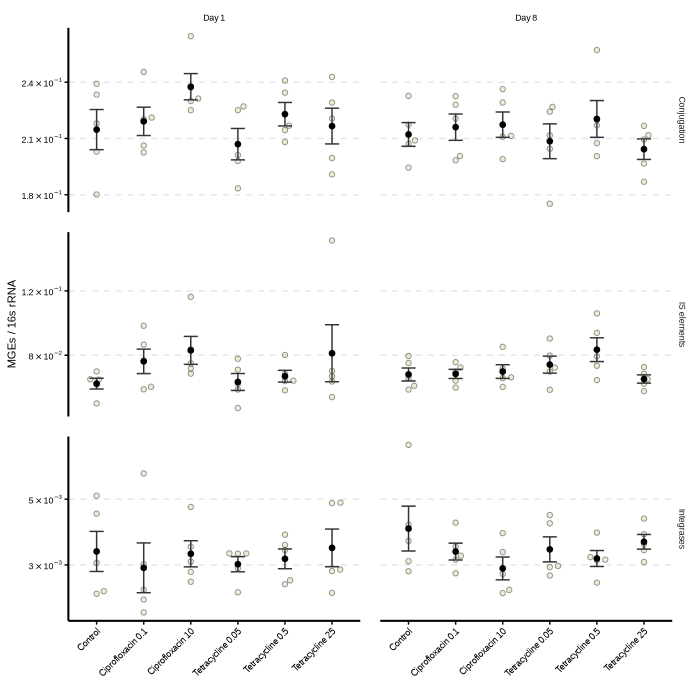

In [83]:
%%R -i df_MGE_class -w 700 -h 700 -r 100

df_MGE_class$Treatment <- factor(df_MGE_class$Treatment, 
                                   levels = c("Input", "Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                              "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))

df_MGE_class <- filter(df_MGE_class, Treatment != "Input")
# Calculate statistics for plot
summary_data <- df_MGE_class %>%
  group_by(Day, Type, Treatment) %>%
  summarise(
    mean_count = mean(Count_normalized, na.rm = TRUE),
    sd_count = sd(Count_normalized)/sqrt(n()),
    .groups = "drop"
  )

break_val <- 4
y_lab <- "MGEs / 16s rRNA"

plot_MGE_class <- ggplot(df_MGE_class, aes(x = Treatment, y = Count_normalized)) +
    geom_beeswarm(fill = "#C1D998", size = 1.5, cex = 3, alpha = 0.4, shape = 21, color ="black") +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = "white", 
                  width = 0.25,
                  size = 0.3) +
    geom_errorbar(data = summary_data,
                  aes(y = mean_count, 
                      ymin = mean_count - sd_count, 
                      ymax = mean_count + sd_count),
                  colour = color_stats, 
              width = 0.3,
                  size = 0.5) +
    geom_point(data = summary_data,
               aes(y = mean_count),
               fill = color_stats,
               size = 1.6) +
  facet_grid(Type~Day, scales = "free", space = "free_x") + 
 scale_y_continuous(
    n.breaks = break_val,
       labels = function(x) {
        parse(text = gsub("e", " %*% 10^", scales::scientific(x)))
    }
  ) +
  
  theme(
    legend.key = element_blank(),
    strip.text.x = element_text(colour = "black"),
    panel.spacing = unit(1, "lines"),
    strip.background = element_rect(colour = NA, fill = NA),
    axis.line = element_line(size = 0.7, colour = "black"),
    panel.background = element_rect(fill = NA),
    axis.text.y = element_text(color = "black"),
    axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
    axis.ticks = element_line(color = 'black'),
    panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
    panel.grid.major.x = element_blank(),
    legend.position = "none",
    plot.title = element_blank(),
    text = element_text(size = 8)
  ) +
  ylab(y_lab) +
  xlab("")


print(plot_MGE_class)

**Figure**: Cumulative abundance of MGE classes involved in the transfer of antibiotic resistance genes. 

In [84]:
def get_Gene(sample):
    if '|ARO:' in sample:
        return sample.split("|")[3].split("_[")[0]
    else:
        return sample.split("|")[-1]
    
def get_significance_stars(fdr):
    if fdr < 0.001:
        return '***'
    elif fdr < 0.01:
        return '**'
    elif fdr < 0.05:
        return '*'
    else:
        return 'ns'

dict_MGE_diff = {
    "Gene_name":[],
    "Treatment":[],
    "Day":[],
    "Diff":[],
    "FDR":[]
}

min_nonzero = df_MGE_normalized[df_MGE_normalized['Count_normalized'] > 0].Count_normalized.min()
pseudocount = min_nonzero

#  Sum coverage for each position per gene 
# Since we did the abundance test on lets say all istA in a sample we need to use the same methodology here
coverage_sum = coverage_df_mge.groupby(["Gene_name", "Sample", "Treatment_clean", "Day", "position", "Replicate"]).coverage.sum().reset_index(name = "Coverage_sum")

for index, row in mge_signif.iterrows():
    name = row["Gene"]
    treatment = row["Treatment"]
    day = row["Day"]
    FDR = row["FDR"]
    logFC = row["logFC"]
    
    df_tmp = df_MGE_normalized[(df_MGE_normalized.Day == day) & (df_MGE_normalized.Treatment.isin(["Control", treatment])) & (df_MGE_normalized.Gene == name)]
    
    # Determine which samples to check based on logFC
    check_treatment = treatment if logFC > 0 else "Control"
    df_tmp_coverage  = coverage_sum[(coverage_sum.Day == day) & (coverage_sum.Treatment_clean == check_treatment) & (coverage_sum.Gene_name == name)]
    
    df_tmp_coverage_median = df_tmp_coverage.groupby("Replicate").Coverage_sum.median()
    list_median_coverage = df_tmp_coverage_median.values.tolist()
    
    # Calculate number of samples with abundance above 5 and filter
    median_coverage_pass = [i for i in list_median_coverage if i >= 1]
    median_coverage_pass_len = len(median_coverage_pass)
    
    if median_coverage_pass_len >= 3:
        for rep in df_tmp.Replicate.unique():
            val_treatment = df_tmp[(df_tmp.Replicate == rep) & (df_tmp.Treatment == treatment)].Count_normalized
            val_control = df_tmp[(df_tmp.Replicate == rep) & (df_tmp.Treatment == "Control")].Count_normalized
            
               
            # Handle empty or zero values for treatment
            if val_treatment.empty or val_treatment.values[0] == 0:
                val_treatment_value = pseudocount
            else:
                val_treatment_value = val_treatment.values[0] + pseudocount
                
            # Handle empty or zero values for control
            if val_control.empty or val_control.values[0] == 0:
                val_control_value = pseudocount
            else:
                val_control_value = val_control.values[0] + pseudocount
            
            Diff = val_treatment_value / val_control_value
            
            dict_MGE_diff["Day"].append(day)
            dict_MGE_diff["Treatment"].append(treatment)
            dict_MGE_diff["Gene_name"].append(name)
    
            dict_MGE_diff["Diff"].append(Diff)
            dict_MGE_diff["FDR"].append(FDR)
        
df_mge_diff = pd.DataFrame.from_dict(dict_MGE_diff)    
df_mge_diff['Significance'] = df_mge_diff['FDR'].apply(get_significance_stars)

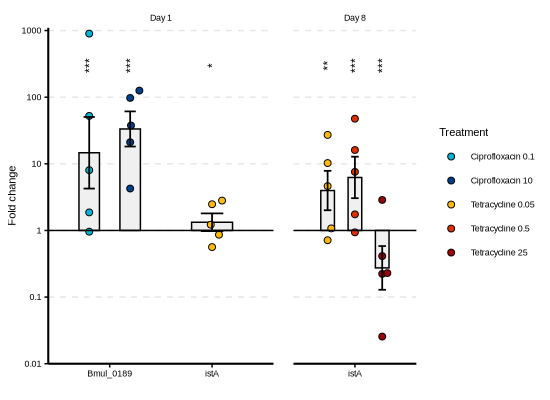

In [85]:
%%R -i df_mge_diff -w 550 -h 400 -r 100

df_mge_diff$Significance <- factor(df_mge_diff$Significance, 
                                   levels = c("*", "**", "***"))

# Calculate statistics for plot
summary_data <- df_mge_diff %>%
  group_by(Day, Gene_name, Treatment) %>%
  summarise(
    # Calculate mean in log10 space then transform back
    mean_count = 10^(mean(log10(Diff), na.rm = TRUE)),
    # Calculate standard error in log10 space
    se_log = sd(log10(Diff))/sqrt(n()),
    # Calculate error bar limits by transforming back from log space
    ymin = 10^(mean(log10(Diff)) - se_log),
    ymax = 10^(mean(log10(Diff)) + se_log),
    .groups = "drop"
  ) 

# Get unique significance values for each combination
sig_data <- df_mge_diff %>%
  select(Day, Gene_name, Treatment, Significance) %>%
  distinct()

max_y <- 15  
sig_y <- max_y * 0.95  

plot_individual_MGE <- ggplot() +
  geom_bar(data = summary_data, 
           aes(x = Gene_name, y = mean_count, group = Treatment),
           position = position_dodge(width = 0.8),
           stat = "identity", 
           width = 0.4, 
           fill = "#f0f0f0", 
           color = "black", 
           show.legend = FALSE) +
  # Beeswarm with fill aesthetic and its own guide name
  geom_beeswarm(data = df_mge_diff,
                aes(x = Gene_name, y = Diff, fill = Treatment, group = Treatment),
                dodge.width = 0.8,
                size = 2, 
                cex = 5, 
                shape = 21,
                show.legend = TRUE) +
   scale_fill_manual(values=c('#00b4d8','#023e8a','#ffba08','#dc2f02','#9d0208')) +
    new_scale_fill() +
    new_scale_color() +
  # Significance dots with color aesthetic and its own guide name
  geom_text(data = sig_data,
             aes(x = Gene_name, y = 300, label = Significance, group = Treatment),
             position = position_dodge(width = 0.8),
             size = 3,
             angle = 90) +
  # Two separate scales with different guide names
  geom_errorbar(data = summary_data,
                aes(x = Gene_name,
                    y = mean_count, 
                    ymin = ymin, 
                    ymax = ymax,
                    group = Treatment),
                position = position_dodge(width = 0.8),
                colour = "black", 
                width = 0.22,
                size = 0.6,
                show.legend = FALSE) +
  facet_grid(~Day, scales = "free", space = "free_x") + 
  scale_y_continuous(expand = c(0, 0), 
                      limits = c(0.01, 1100), 
                      breaks = c(0.01, 0.1, 1, 10, 100, 1000),
                      labels = c("0.01", "0.1", "1", "10", "100", "1000"),
                     trans = 'log10') +
  theme(
    legend.key = element_blank(),
    strip.text.x = element_text(colour = "black"),
    panel.spacing = unit(1, "lines"),
    strip.background = element_rect(colour = NA, fill = NA),
    axis.line = element_line(size = 0.7, colour = "black"),
    panel.background = element_rect(fill = NA),
    axis.text.y = element_text(color = "black"),
    axis.text.x = element_text(color = "black"),#, angle = 45, hjust = 1),
    axis.ticks = element_line(color = 'black'),
    panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
    panel.grid.major.x = element_blank(),
    plot.title = element_blank()
  ) +
  theme(text = element_text(size = 8)) + 
  ylab("Fold change") +
  xlab("") +
  geom_hline(yintercept = 1) 

print(plot_individual_MGE)


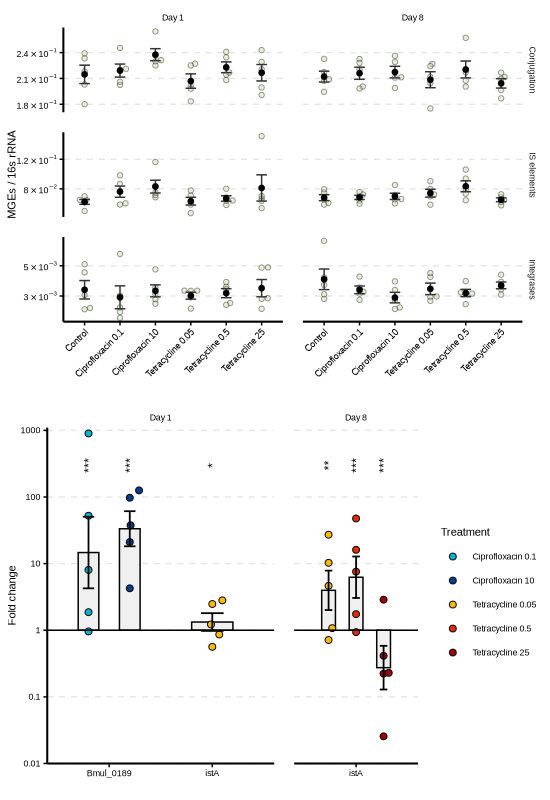

In [86]:
%%R -w 550 -h 800 -r 100

ggarrange(plot_MGE_class ,plot_individual_MGE, ncol=1)

**Figure 3: Cumulative abundance of MGE classes and individual genes involved in the transfer of antibiotic resistance genes**. Abundance of A) genes involved in conjugation, B) IS elements, and C) integrases, all expressed as cumulative abundance per 16S rRNA. Finally, D) shows the log10 fold change in individual MGEs. Statistical significance was determined by a paired Student's t-test for plots A-C, or edgeR for D. After the tests the p-values were corrected for multiple testing using the FDR approach. The stars denote statistical significance after correction: * p <0.05, ** p<0.01, *** p<0.001. Error bars represent standard error of the mean. 

### MAGs

In [ ]:
df_MAG_Abundance_filter_ARG_yes = df_MAG_Abundance_filter[df_MAG_Abundance_filter.Name.isin(df_MAG_quality_comb[df_MAG_quality_comb.ARG_detected == "Yes"].Name)]
df_MAG_Abundance_filter_ARG_yes["Name"] =  df_MAG_Abundance_filter_ARG_yes.Name.str.split(".").str[-1]

# For specific values
days = df_MAG_Abundance_filter_ARG_yes.Day.unique()
treatments = df_MAG_Abundance_filter_ARG_yes.Treatment.unique()
treatments = list(treatments) + ["Tetracycline 25"]  
Name = df_MAG_Abundance_filter_ARG_yes.Name.unique()
Replicates = df_MAG_Abundance_filter_ARG_yes.Replicate.unique()

# Create all combinations
combinations = list(product(days, treatments, Name, Replicates))
df_combinations = pd.DataFrame(combinations, columns=['Day', 'Treatment', 'Name', 'Replicate'])

# Remove combinations which does not exist
df_combinations_rel = df_combinations[~((df_combinations.Treatment != "Input") & (df_combinations.Day == "Day 0"))]
df_combinations_rel = df_combinations_rel[~((df_combinations_rel.Treatment == "Input") & (df_combinations_rel.Day != "Day 0"))]
df_full = pd.merge(df_MAG_Abundance_filter_ARG_yes[['Day', 'Treatment', 'Name', 'coverage_median', 'Replicate']],
                   df_combinations_rel, 
                   on=['Day', 'Treatment', 'Name', 'Replicate'], 
                   how='outer').fillna(0) 

/tmp/ipykernel_60262/3570367302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MAG_Abundance_filter_ARG_yes["Name"] =  df_MAG_Abundance_filter_ARG_yes.Name.str.split(".").str[-1]


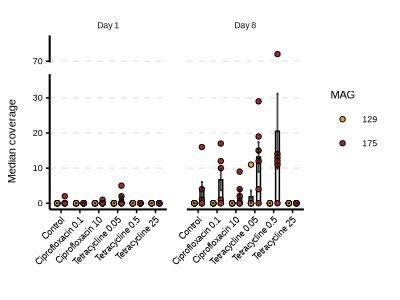

In [88]:
%%R -i df_full -w 400 -h 300 -r 100


df_full$Treatment <- factor(df_full$Treatment, 
                           levels = c("Input", "Control", "Ciprofloxacin 0.1", "Ciprofloxacin 10", 
                                    "Tetracycline 0.05", "Tetracycline 0.5", "Tetracycline 25"))
df_full <- filter(df_full, Day != "Day 0")

# Modify the summary data calculation to include count of observations
summary_data <- df_full %>%
  group_by(Day, Name, Treatment) %>%
  summarise(
    mean_count = mean(coverage_median, na.rm = TRUE),
    sd_count = sd(coverage_median+0.0001)/sqrt(n()),
    n_obs = n(),  # Count number of observations
    .groups = "drop"
  ) %>%
  # Only keep sd where there are multiple observations
  mutate(
    sd_count = ifelse(n_obs > 1, sd_count, NA)
  )

plot_MAG_abundance <- ggplot() +
    geom_bar(data = summary_data, 
             aes(x = Treatment, y = mean_count, group = Name),
             position = position_dodge(width = 0.8),
             stat = "identity", 
             width = 0.4, 
             fill = "#f0f0f0", 
             color = "black", 
             show.legend = FALSE) +
    geom_point(data = df_full,
               aes(x = Treatment, y = coverage_median, fill = Name, group = Name),
               position = position_dodge(width = 0.8),
               size = 1.5, 
               shape = 21,
               show.legend = TRUE) +
    scale_fill_manual(name="MAG", values=c('#e09f3e','#9e2a2b')) +
    # Error bars only where sd_count is not NA
    geom_errorbar(data = summary_data %>% filter(!is.na(sd_count)),
                 aes(x = Treatment,
                     y = mean_count, 
                     ymin = mean_count - sd_count, 
                     ymax = mean_count + sd_count,
                     group = Name),
                 position = position_dodge(width = 0.8),
                 colour = "black", 
                 width = 0.22,
                 size = 0.6,
                 alpha = 0.7,
                 show.legend = FALSE) +
    scale_y_break(breaks = c(35, 70), space = 0.2, scales = c(0.2, 1), 
                  ticklabels = list(c(60, 70), 
                                  seq(0, 40, by = 10))) + 
    facet_grid(~Day, space ="free", scales = "free") +
    theme(
        panel.spacing = unit(1, "lines"),
        strip.background = element_rect(colour = NA, fill = NA),
        axis.line = element_line(size = 0.7, colour = "black"),
        panel.background = element_rect(fill = NA),
        axis.text.y = element_text(color = "black"),
        axis.text.x = element_text(color = "black", angle = 45, hjust = 1),
        axis.ticks = element_line(color = 'black'),
        panel.grid.major.y = element_line(colour = "#E6E6E6", linetype = "dashed"),
        panel.grid.major.x = element_blank(),
        plot.title = element_blank(),
        axis.text.y.right = element_blank(),  
        axis.ticks.y.right = element_blank(),
        axis.title.y.right = element_blank(),
        axis.line.y.right = element_blank()  
    ) +
    theme(text = element_text(size = 8)) + 
    ylab("Median coverage") +
    guides(fill = guide_legend(nrow = 2)) +
    xlab("") +
    ylim(0, max(df_full$coverage_median, na.rm = TRUE) * 1.1)

print(plot_MAG_abundance)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


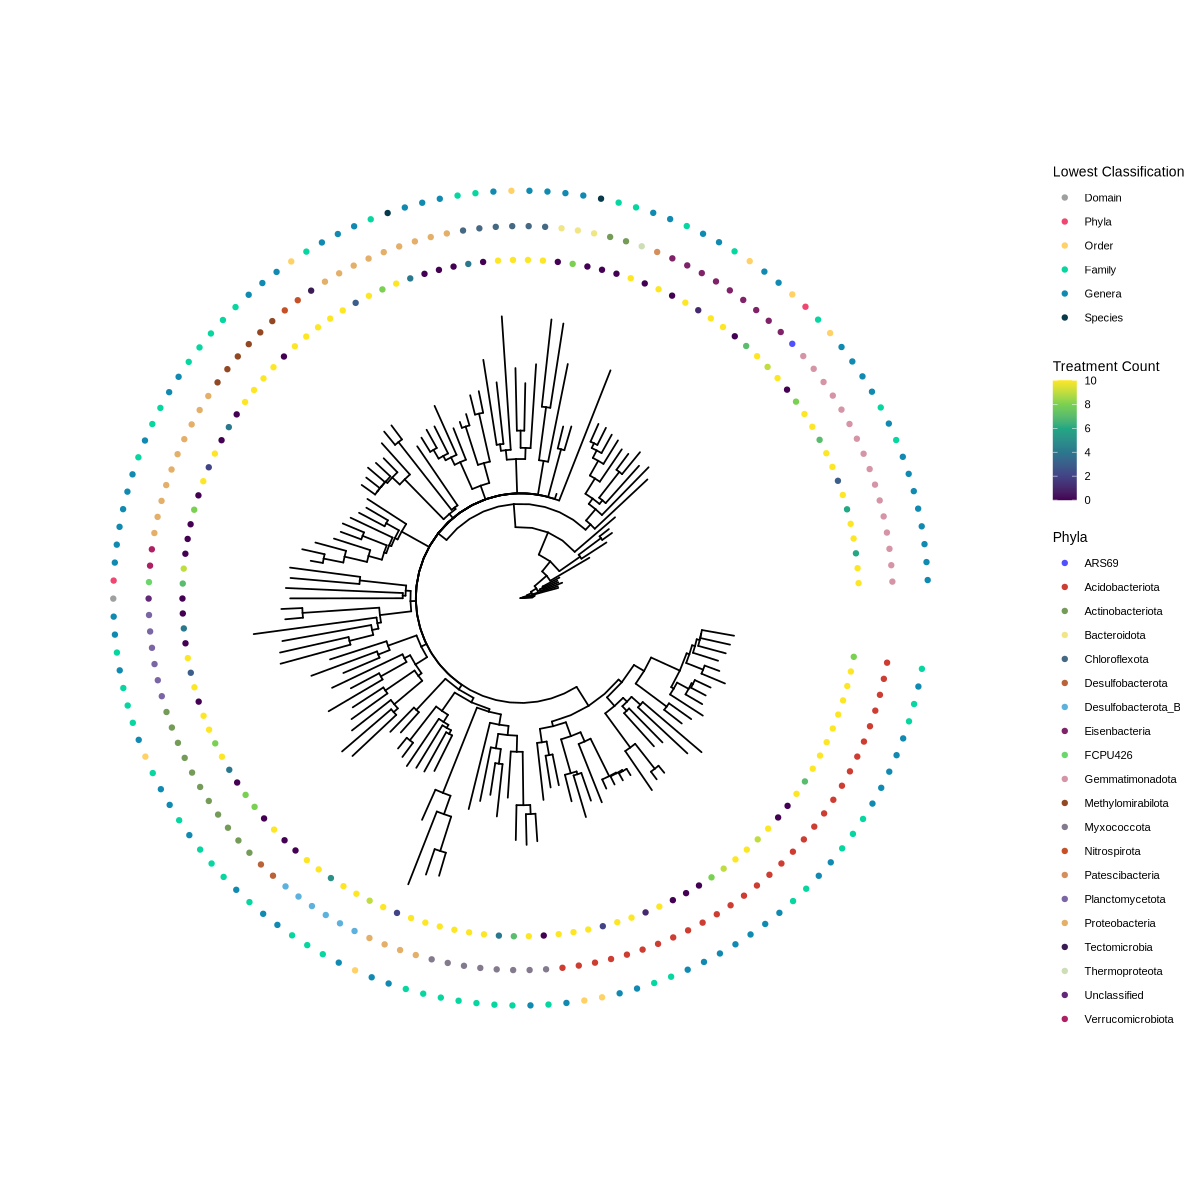

In [89]:
%%R -w 1200 -h 1200 -r 100 -i df_MAG_quality_comb -i df_MAG_treatment_nr_comb

library(ape)
library(ggtree)

# Function to prune, bind, and root trees together
prune_bind_and_root_trees <- function(input_dir, genomes_of_interest) {
  # List all GTDB-TK tree files in the input directory
  tree_files <- list.files(
    path = input_dir, 
    pattern = "gtdbtk\\.bac120\\.classify\\.tree\\.[0-9]+\\.tree$", 
    full.names = TRUE
  )
  
  # Manually add the gtdbtk.ar53.classify.tree file
  ar53_file <- file.path(input_dir, "gtdbtk.ar53.classify.tree")
  tree_files <- c(tree_files, ar53_file)
  
  # Read and prune the first tree
  first_tree <- read.tree(tree_files[1])
  pruned_tree <- drop.tip(first_tree, setdiff(first_tree$tip.label, genomes_of_interest))
  
  # Loop through remaining tree files, prune, and bind them
  for (i in 2:length(tree_files)) {
    next_tree <- read.tree(tree_files[i])
    pruned_next_tree <- drop.tip(next_tree, setdiff(next_tree$tip.label, genomes_of_interest))
    
    # Bind pruned trees together
    pruned_tree <- bind.tree(pruned_tree, pruned_next_tree)
  }
  
  # Root the combined tree to ensure it has a common root
  # You can root by the midpoint or by a specific tip, depending on your data
  rooted_tree <- root(pruned_tree, outgroup = genomes_of_interest[1], resolve.root = TRUE)
  
  return(rooted_tree)  # Return the final combined and rooted tree
}

# Example usage
input_directory <- "manuscript_analysis/data/genome_resolved/gtdb-tk"
genomes_of_interest <- filter(df_MAG_quality_comb, Include == "Yes")$Name  

# Combine, prune, and root trees
combined_rooted_tree <- prune_bind_and_root_trees(input_directory, genomes_of_interest)

df_MAG_quality_comb_filtered <- df_MAG_quality_comb %>%
  filter(Name %in% combined_rooted_tree$tip.label)

# Define colors and order for lowest classification
classification_colors <- c('#9e9f9f', '#ef476f','#ffd166','#06d6a0','#118ab2','#073b4c')
classification_order <- rev(c("Species", "Genera", "Family", "Order", "Phyla", "Domain"))

names(classification_colors) <- classification_order

# Plot the combined rooted tree
tax_tree <- ggtree(combined_rooted_tree, layout = 'fan', open.angle = 10, size=0.6) +
    
    # Domain (discrete color scale for the first ring)
    geom_fruit(
        data = df_MAG_treatment_nr_comb,
        geom = geom_point,
        mapping = aes(y = Genome, color = count),
        size = 1.5,
        offset = 0.1 
    ) +
  scale_color_viridis_c(
        option = "viridis",  # viridian-like color palette
        name = "Treatment Count",
        breaks = c(0,2,4,6,8,10)
    ) +
    
    # Add a new color scale for the next layer
    new_scale_color() +
        geom_fruit(
        data = df_MAG_quality_comb_filtered,
        geom = geom_point,
        mapping = aes(y = Name, color = Phyla),
        size = 1.5,
        offset = 0.11 
    ) +
        scale_color_manual(
        values = paletteer_d("ggsci::default_igv"), 
        
    ) + 
     new_scale_color() +
    # Completeness (continuous fill scale for the second ring)
    geom_fruit(
        data = df_MAG_quality_comb_filtered,
        geom = geom_point,
        mapping = aes(y = Name, color = lowest_classification),
        size = 1.5,
        pwidth = 0.1,
        offset = 0.115
    ) +    

    scale_color_manual(
        values = classification_colors, 
        name = "Lowest Classification",
        breaks = classification_order,
        drop = FALSE
    ) +   
           theme(
        legend.position = "right",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        plot.title = element_text(size = 16, face = "bold"),
        plot.subtitle = element_text(size = 14)
    ) 
           
# Display the plot
print(tax_tree)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


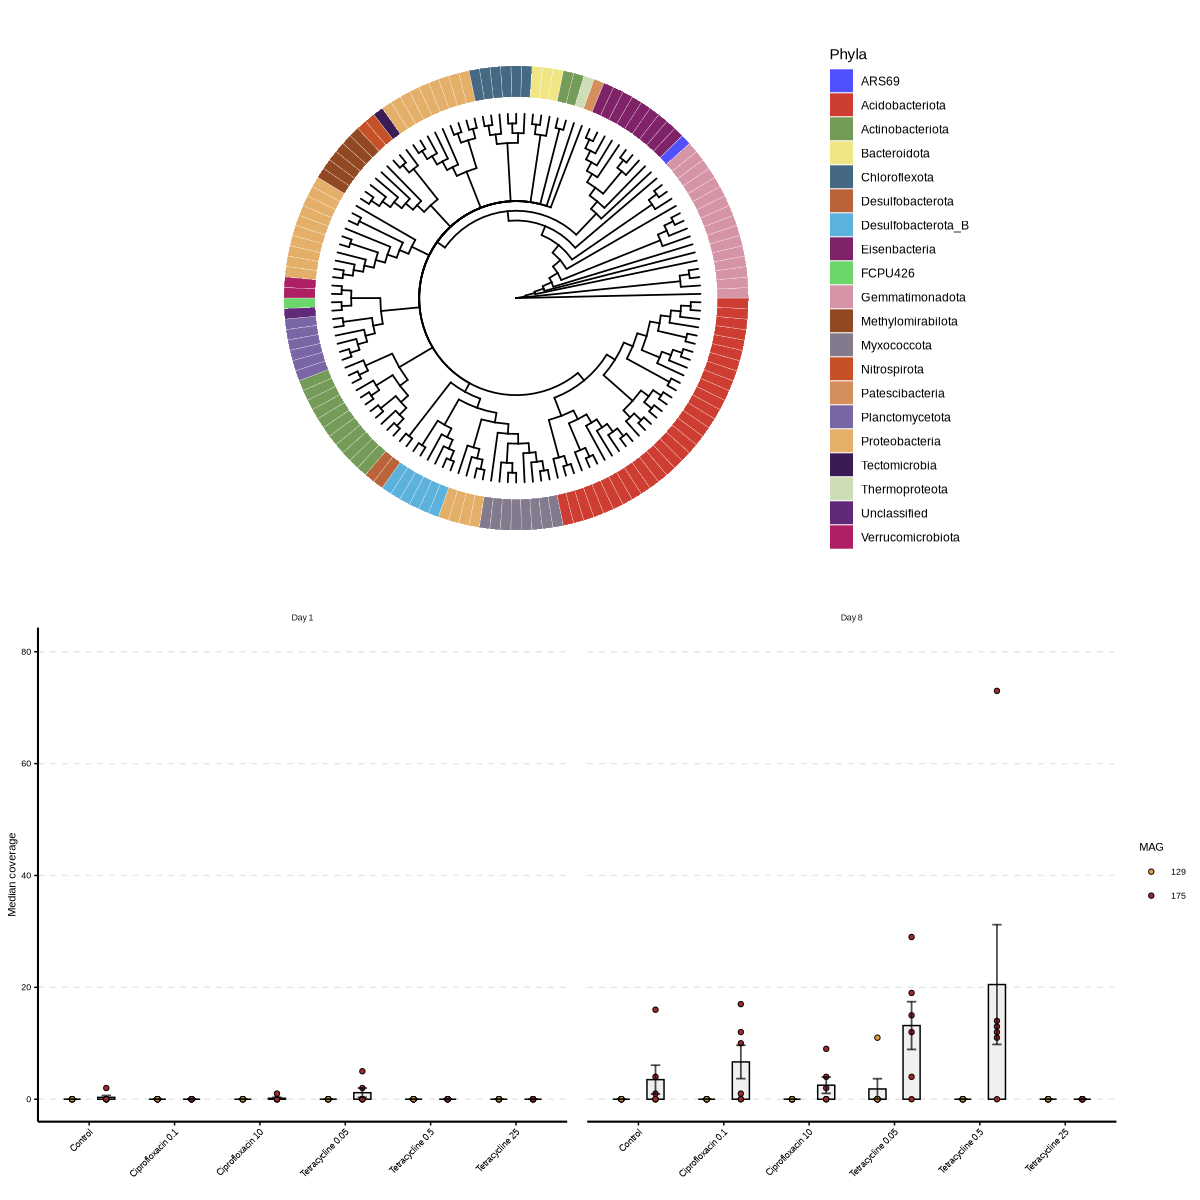

In [90]:
%%R -w 1200 -h 1200 -r 100 -i df_MAG_quality_comb -i df_MAG_treatment_nr_comb


# Your existing tree processing code remains the same
input_directory <- "manuscript_analysis/data/genome_resolved/gtdb-tk"
genomes_of_interest <- filter(df_MAG_quality_comb, Include == "Yes")$Name  

# Combine, prune, and root trees
combined_rooted_tree <- prune_bind_and_root_trees(input_directory, genomes_of_interest)
df_MAG_quality_comb_filtered <- df_MAG_quality_comb %>%
  filter(Name %in% combined_rooted_tree$tip.label)

# Create a data frame for Phyla
phyla_data <- df_MAG_quality_comb_filtered %>%
  select(Name, Phyla) %>%
  as.data.frame() %>%
  remove_rownames() %>%
  column_to_rownames("Name")

# Create base tree
p <- ggtree(combined_rooted_tree, size=0.6, 
            branch.length='none', layout='circular')

# Add first heatmap with Phyla colors
p1 <- gheatmap(p, phyla_data, offset=0.1, width=0.17,
               colnames=FALSE) +
  scale_fill_paletteer_d("ggsci::default_igv") +
  labs(fill = "Phyla")

# Display the plot
print(p1)

ggarrange(p1, plot_MAG_abundance, ncol = 1)

S**upplementary 2: The effect of antibiotic exposure on metagenome assembled genomes (MAGs), as well as their taxonomic classification.** A) Median abundance of the two MAGs which carried genes included in the CARD database. B) Taxonomic tree created from the MAGs. The colors in the outer circle correspond to which phyla each MAG was assigned to. The two MAGs carrying genes included in the CARD database are indicated by the two red boxes in the inner circle MAG 129 was classified to belong in the Pseudomonas genus, while MAG 175 was taxonomically classified as Azotobacter chroococcum. Both MAGs carried the rsmA post transcriptional gene, which is indirectly involved in antibiotic resistance. To determine statistical differences in abundance for the MAGs, edgeR was used, followed by a FDR correction of the p-values.
 


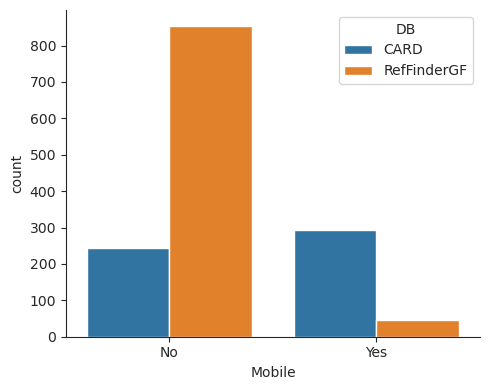

In [ ]:
# Set the figure size (optional)
plt.figure(figsize=(5, 4))  # Adjust the size as needed

# Create the Seaborn barplot
plot_on_plasmid = sns.barplot(data=df_arg_db_count_plasmid, x="Mobile", y="count", hue="DB")

# Remove the top and right spines
sns.despine()

# Adjust the layout to prevent clipping of labels
plt.tight_layout()


**Supplementary 3:** Shows the number of ARG clusters at 95% which has at least one member detected, or not detected on a plasmid per database. 